# **QLoRA Fine-Tuning Notebook**

### **QLoRA Fine-Tuning Readme:**

For more information on QLoRA Fine-Tuning, refer to the [QLoRA Fine-Tuning Readme](../qlora_finetuning_readme.md).

### **About This Notebook:**

This notebook demonstrates `QLoRA Fine-Tuning`. Compared to the [LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning.ipynb), the following modifications have been made:

1. The `bitsandbytes==0.44.1` library is installed to enable model quantization.
2. Base model weights are loaded into VRAM with `4-bit quantization`. Specifically, the model is first quantized to 8-bit and then further quantized to 4-bit using NF4 (Normal Float 4-bit) quantization. During the computation phase, 4-bit quantized weights are upcast to bfloat16 for operations.
3. The base model is loaded with the `eager` attention implementation. While this provides less VRAM savings compared to the `flash_attention_2` implementation used in LoRA fine-tuning, it avoids the mixed-precision issues encountered when using `flash_attention_2` in QLoRA fine-tuning.

### **Supporting Python Files:**

This notebook utilizes the following external Python files:

- `my_login.py`: Contains reusable login functions (e.g., for Hugging Face and Weights & Biases). Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils.py`: Contains general-purpose utility functions for fine-tuning. Created in the [Complete LoRA Fine-Tuning Notebook](../../2.1_lora_finetuning/run_1_a6000_48g_x1/lora_finetuning_complete.ipynb).
- `my_utils_qlora.py`: Contains utility functions specific to QLoRA fine-tuning. Created within this notebook.

### **Experiment Settings:**

This experiment is conducted within a pod (container instance) provided by [RunPod](https://runpod.io). The configurations are as follows:

- `Template (Docker Container Image)`: runpod/pytorch:2.4.0-py3.11-cuda12.4.1-devel-ubuntu22.04
- `Volume Disk`: 150GB (model checkpoints storage)
- `GPU Setup`: 1 Nvidia RTX A5000 GPU (24GB VRAM)

---
# **Step 1: Preparation**

## 1.1 Install Necessary Python Packages

In [1]:
!python -m pip install -q -U pip            # [optional] upgrade pip
!pip install huggingface_hub==0.25.1 -q -U  # hf lib to login to huggingface and download dataset, model
!pip install hf_transfer==0.1.8 -q -U       # hf lib to speed up huggingface data transfer 
!pip install transformers==4.46.0 -q -U     # hf lib to load model and processor(tokenizer)
!pip install accelerate==0.34.2 -q -U       # hf lib to support 'device_map', restart kernel required after installation
!pip install flash-attn==2.6.3 -q -U        # to reduce vram usage for llama model, restart kernel recommended after installation
!pip install datasets==3.0.0 -q -U          # hf lib to load dataset
!pip install peft==0.13.0 -q -U             # hf lib to support lora fine-tuning
!pip install matplotlib==3.9.2 -q -U        # to plot similarity score comparison graphs
!pip install tensorboard==2.18.0 -q -U      # to support logging with tensorboard
!pip install wandb==0.18.1 -q -U            # to support logging with weights and biases (wandb)
!pip install ipython==8.28.0 -q -U          # to enable %% magic functions in a jupyter notebook
!pip install bitsandbytes==0.44.1 -q -U     # to support quantization for enabling QLoRA

Reason for being yanked: This version unfortunately does not work with 3.8 but we did not drop the support yet


## 1.2 Restart Kernel to Activate Installed Packages

---
# **Step 2: Pre-training**

## 2.1 Log in to Required Accounts (e.g., Hugging Face, Weights & Biases) 

In [1]:
import my_login
# Log in to the Hugging Face account to access the Idefics2 model and the dataset
my_login.login_hf()
# Log in to the Weights & Biases account to enable tracking of training progress
my_login.login_wandb()

==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 2.2 Load the Processor (Tokenizer) and the Base Model

In [2]:
%%writefile my_utils_qlora.py
#--------------- Functions in QLoRA Fine Tuning ---------------
# 1) Create Quantization Config for QLoRA
# !pip install bitsandbytes==0.44.1 -q -U
import torch
from transformers import BitsAndBytesConfig
def create_quantization_config():
    print("==> Creating Quantization Configuration...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,                       # Load model weights in 4-bit precision
        bnb_4bit_use_double_quant=True,          # First quantize weights to 8-bit, then to 4-bit
        bnb_4bit_quant_type="nf4",               # Use NF4 (Normal Float 4-bit) quantization
        bnb_4bit_compute_dtype=torch.bfloat16    # Upcast 4-bit precision weights to bfloat16 during computation
    )
    return bnb_config

Writing my_utils_qlora.py


In [3]:
import my_utils
import my_utils_qlora

# Load processor
processor = my_utils.load_processor()
my_utils.print_processor_info_to_file(processor, './results/model_info/original_processor_info.txt')

# Load model
bnb_config = my_utils_qlora.create_quantization_config()
base_model = my_utils.load_model(quantization_config=bnb_config)
my_utils.print_model_info_to_file(base_model, './results/model_info/base_model_info.txt')
my_utils.print_model_parameters_to_file(base_model, './results/model_info/base_model_parameters.txt')

==> Loading processor...


processor_config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


preprocessor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32003, bos_token: <s>, eos_token: </s>, pad_token: <unk>
==> For complete processor info, refer to ./results/model_info/original_processor_info.txt.
==> Creating Quantization Configuration...
==> Loading model...


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.64G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/base_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, True)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, True)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, True)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (663552, torch.uint8, cuda, False)
model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.v_proj.weight (663552, torch.uint8, cuda, False)
model.vision_model.encoder.layers.0.self_attn.v_proj.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.

## 2.3 Load the Dataset

In [4]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

==> Loading hf dataset...


README.md:   0%|          | 0.00/648 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/82 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/74 [00:00<?, ? examples/s]

## 2.4 Perform Inference with the Base Model to Establish a Baseline

==> Performing batch inference and saving results to ./results/inference_results/inference_results_before_finetuning.csv ...
==> [Batch: 1/25] Data in batch: 3
==> [Batch: 1/25][Data: 1/3] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


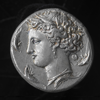

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin. On the coin there is a picture of a person.
==> Ground truth answer: The exhibit features the Syracuse dekadrachm, a remarkable coin from antiquity renowned for its exquisite artistry and high relief, crafted by notable designers like Kimon and Euinatos. This coin has captivated enthusiasts for over 2,500 years, raising questions about how the ancient Greeks achieved such beauty using only hand tools. An interesting connection to American history is found in Theodore Roosevelt, who, while known for his political reforms, also sought to enhance American coinage. Disappointed by the mundane designs of contemporary coins, he envisioned a more artistic approach that would rival the elegance of class

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


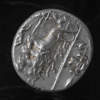

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a coin.
==> Ground truth answer: This exhibit highlights the Syracuse dekadrachm, a stunning ancient coin that exemplifies the artistry of its time, designed by renowned craftsmen such as Kimon and Euinatos. With its striking high relief, this coin has fascinated collectors for more than two millennia, prompting inquiries into the techniques used by the Greeks to achieve such intricate designs without modern tools. A significant figure connected to this coin is Theodore Roosevelt, who, while recognized for his political reform efforts, also sought to elevate the quality of American currency. Frustrated by the lackluster designs of contemporary coins, he advocated for a more artistic 

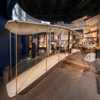

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A full size replica of the Wright brothers first plane is on display here.
==> Ground truth answer: This exhibit showcases the remarkable 1903 Wright Flyer, the first successful powered airplane, which heralded the beginning of the aerial age. Designed by Wilbur and Orville Wright, this biplane features a 12-horsepower Wright horizontal four-cylinder engine that drives two pusher propellers through a chain-and-sprocket transmission. Notably, it employs linear skids for landing gear and is finished with natural fabric, devoid of any sealant or paint. The Wright brothers' groundbreaking achievement on December 17, 1903, at Kitty Hawk, North Carolina, included a 12-second flight covering 36 meters, with Orville pi

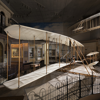

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A collection of old fashioned planes are on display in a museum.
==> Ground truth answer: The exhibit features the iconic 1903 Wright Flyer, a pioneering aircraft that marked the dawn of powered flight. Built by the Wright brothers, Wilbur and Orville, this biplane is powered by a 12-horsepower engine that operates two pusher propellers via a sprocket-and-chain system. Its unique landing gear consists of linear skids, and it is covered in natural fabric, without any paint or sealant. The Flyer made its historic first flight on December 17, 1903, in Kitty Hawk, North Carolina, with Orville at the controls for a brief 12-second journey. The Wrights' innovative methods, including wind tunnel te

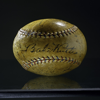

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a ball on the surface.
==> Ground truth answer: This exhibit features a remarkable autographed baseball from the legendary 1926 New York Yankees, signed by iconic players including Hall of Famers Babe Ruth and Lou Gehrig. Ruth, known for his extraordinary hitting prowess, and Gehrig, celebrated for his record of 2,130 consecutive games played, both left an indelible mark on the sport. Gehrig's battle with amyotrophic lateral sclerosis (ALS), which is often referred to as Lou Gehrig's disease, showcased his incredible humility and resilience, inspiring many during his illness. The baseball, which measures approximately 3 inches in diameter, is crafted with a cork center, wool layers, and

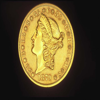

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a coin with some text and a picture of a woman.
==> Ground truth answer: This exhibit features a remarkable coin from the United States Mint in Philadelphia, showcasing a unique design that reflects a significant moment in American numismatic history. The obverse displays the Liberty head facing left, with the date inscribed below and details about weight and fineness surrounding it. The reverse features an eagle, similar to the standard twenty-dollar coin, but replaces the traditional motto "IN GOD WE TRUST" with "DEO EST GLORIA." This coin was part of a series inspired by the desire to enhance the competitiveness of American currency in global markets, alongside the creation of the fo

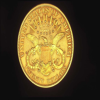

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: United States of America Twenty Dollars.
==> Ground truth answer: This exhibit highlights a significant gold coin minted by the United States Mint in Philadelphia, showcasing both artistic and economic significance. The coin features a Liberty head on the obverse, with the date inscribed below and weight and fineness details surrounding it. On the reverse, an eagle is depicted, but intriguingly, it bears the Latin phrase "DEO EST GLORIA" instead of the more familiar "IN GOD WE TRUST." This design was part of an initiative aimed at improving the international appeal and convertibility of American coins, paralleling the introduction of the four-dollar gold coin, or Stella. Only nine gold examp

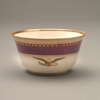

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a cup.
==> Ground truth answer: The exhibit features Abraham Lincoln's coffee cup, a poignant artifact from a pivotal moment in American history. This ceramic cup, adorned in purple with white and gold trim, was left behind by President Lincoln on a windowsill at the White House on the evening of April 14, 1865, just before he attended Ford's Theatre. A White House servant preserved this cup as a memento of that tragic night, which marked the end of Lincoln's life and the Civil War. In 1887, Captain D.W. Taylor gifted it to Robert Todd Lincoln, the president's eldest son, ensuring its legacy as a cherished family heirloom. The cup is now part of the Smithsonian's National Museum of American History, sho

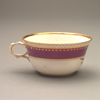

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a cup with a handle.
==> Ground truth answer: This exhibit showcases a significant artifact: Abraham Lincoln's coffee cup, which dates back to 1887. The cup was a gift from Captain D.W. Taylor to Robert Todd Lincoln, the president's eldest son. It holds a somber history, as it was left behind by Lincoln on April 14, 1865, just before he went to Ford's Theatre for what would be his final evening. A White House servant preserved the cup, recognizing its importance as a relic of that fateful night. Crafted from ceramic and featuring a striking purple color with white and gold trim, the cup measures approximately 3 1/4 inches in height. It is housed at the Smithsonian's National Museum o

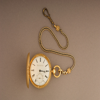

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A watch with a gold chain is on display.
==> Ground truth answer: This exhibit features a remarkable English gold pocket watch that belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for vanity, this exquisite timepiece served as a notable emblem of his achievements as a lawyer. The watch's movement, crafted in Liverpool, represents the high-quality manufacturing of the era, while the case was made by an unidentified American artisan. Notably, this watch boasts one of the finest movements available in England, capable of maintaining accurate time to within seconds daily. A hidden narrative unfolds with engravings made by watchmaker Jonatha

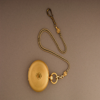

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Gold watch on a chain with a small loop at the bottom.
==> Ground truth answer: This exhibit showcases Abraham Lincoln's gold pocket watch, acquired in the 1850s from a jeweler named George Chatterton in Springfield, Illinois. Although Lincoln was not typically seen as vain, the watch symbolized his professional success as a lawyer. The watch's movement was produced in Liverpool, a hub for watchmaking at the time, while the case was crafted by an unidentified American shop. Known for its exceptional quality, the watch's movement can keep time within seconds daily. A fascinating aspect of this piece is the hidden message engraved by watchmaker Jonathan Dillon, who, during repairs on April 12,

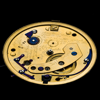

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a watch.
==> Ground truth answer: This display features an exquisite gold pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from Springfield jeweler George Chatterton. While Lincoln was not known for his vanity, this watch served as a prestigious symbol of his accomplishments as a lawyer. The watch's movement was manufactured in Liverpool, a center of watch production, and it is accompanied by a high-quality case made in America. Remarkably, this timepiece has a movement capable of keeping time to within seconds each day. An intriguing story lies within, as watchmaker Jonathan Dillon, while repairing the watc

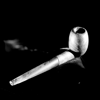

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a pipe on the surface.
==> Ground truth answer: The exhibit features Albert Einstein's iconic pipe, dating back to around 1948. Known for his groundbreaking contributions to theoretical physics, including the theory of relativity, Einstein is also recognized for his distinctive appearance, which prominently included this pipe. Despite reducing his smoking due to medical advice in his later years, he cherished the physical sensation of holding a pipe. This particular pipe shows signs of extensive use, with a noticeable hole worn into its bit. It was gifted to Gina Plunguian, a close friend and admirer of Einstein, before being acquired by the Smithsonian in 1979. This artifact is part of

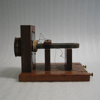

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a machine.
==> Ground truth answer: This exhibit at the National Museum of American History highlights the groundbreaking invention of the telephone by Alexander Graham Bell. On March 7, 1876, Bell was awarded the first patent for an apparatus designed to transmit vocal sounds telegraphically. Just three days later, he successfully communicated with his assistant, Thomas Watson, uttering the iconic words, “Mr. Watson, come here, I want to see you.” Featured in this exhibit is one of the original telephones used during a demonstration between Boston and Salem, Massachusetts, on November 26, 1876. This particular device is notable for its iron diaphragm and dual electromagnets, lacking the wooden casing t

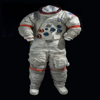

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a mannequin wearing a space suit.
==> Ground truth answer: This exhibit features the Apollo 17 spacesuit, which was worn during the final Apollo mission that successfully landed astronauts on the moon in 1972. Launched on December 7, 1972, aboard a Saturn V rocket, Apollo 17 included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, notable for being the only geologist to have walked on lunar soil. While Evans orbited the moon, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region, where they conducted extensive scientific activities over three days. They completed three moonwalks, collecting a remarkable 110 kil

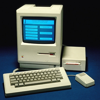

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: An old apple computer with a floppy disc drive and monitor.
==> Ground truth answer: This exhibit features the iconic Apple "Classic" Macintosh Personal Computer, launched in 1984 by Apple Inc. This groundbreaking machine introduced a graphic user interface (GUI) to the world of personal computing, a concept that had its roots in the 1970s at Xerox's Palo Alto Research Center. Apple captured public attention with a memorable Super Bowl XVIII advertisement, marking the Macintosh's debut on January 22, 1984, with a retail price of approximately $2,500. Unlike previous computers that relied on command lines, the Macintosh allowed users to interact with programs through clickable icons, utilizing a single-button mo

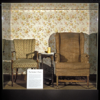

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a glass box. In this box there are two chairs. On this table there is a candle.
==> Ground truth answer: This exhibit features an iconic upholstered wing chair that was prominently used by the character Archie Bunker, portrayed by Carroll O'Connor, in the groundbreaking television series "All in the Family." The chair, with its distinctive orange-yellow woven fabric and sturdy wooden frame, dates back to the 1940s, although its exact origins remain unclear. Initially acquired from a thrift store in Southern California, it served as a significant prop throughout the show's run from 1971 to 1979, until it was replaced by a reproduction in the final season after being donated to the Smithsonian. "All in th

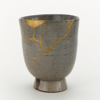

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The cracked glaze on this bowl is known as "Kintsugi", a Japanese philosophy that views damage and repair as part of the history of an object, giving it a more interesting story.
==> Ground truth answer: This exhibit features a remarkable 17th-century tea bowl from the Satsuma ware collection, specifically the White Satsuma type, hailing from Kagoshima prefecture in Japan during the Edo period. The bowl, made of stoneware and finished with a clear, crackled glaze, has a storied past, having been broken and subsequently repaired using the traditional Japanese art of kintsugi, or golden joinery. This technique not only mends the bowl but also accentuates its history by highlighting the cracks with lacquer infused

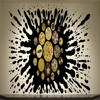

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is an art.
==> Ground truth answer: This exhibition features the captivating work of Yinka Shonibare, a prominent artist born in London in 1962. The display showcases 25 circular canvases of varying sizes, meticulously arranged over a large-scale ink splatter pattern that has been applied using a template. Each canvas is adorned with intricate foliate designs painted in black and gold, utilizing Dutch wax printed fabrics. Shonibare's earlier works are characterized by small square canvases in a grid layout, while his more recent pieces, including this one, challenge traditional boundaries with their dynamic black splatter forms. The artwork draws inspiration from Africa's oil resources, often referred to a

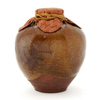

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a brown vase with a brown and red design on it.
==> Ground truth answer: The exhibit titled "Chigusa and the Art of Tea," located at the Arthur M. Sackler Gallery, delves into the intricate relationship between Japanese tea culture and the art of collecting. It highlights how collectors engaged with tea-leaf storage jars through the traditional tea ceremony, known as chanoyu, by bestowing names and adorning these jars with exquisite textiles. Central to this theme is the jar named Chigusa, which evolved from a simple Chinese import into a revered object of beauty and contemplation, while still retaining its functional purpose. Notably, 16th-century tea diaries provide insights into the admiration expres

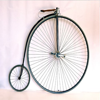

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A bicycle with only one wheel is on display.
==> Ground truth answer: This exhibit at the National Museum of American History celebrates the arrival of spring with a spotlight on an original 1886 Columbia Light Roadster high-wheel bicycle. This remarkable artifact, which originally sold for around $135, was produced by the Pope Manufacturing Co., recognized as the first bicycle manufacturer in the United States. The bicycle features a distinctive configuration with a 53-inch front wheel, supported by 60 spokes, and an 18-inch rear wheel with 20 spokes, available in a range of sizes for riders. Accompanying this bicycle is a historic photograph showcasing one of America's inaugural organized biking tours from 18

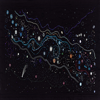

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see some designs.
==> Ground truth answer: The exhibit titled “Milky Way, Starry Night # 2” features the work of Gwich'in artist Margaret Nazon, who hails from Tsiigehtchic in the Northwest Territories of Canada. Created in 2021, this piece reflects Nazon's lifelong fascination with the stars, a passion that she fully embraced in her art later in life after being inspired by Hubble Space Telescope imagery. Nazon's work is distinctive as it incorporates swirling galaxies, a departure from traditional Gwich'in beadwork, showcasing her unique artistic style. This artwork is part of the “Lights Out: Recovering Our Night Sky” exhibition at the Smithsonian's National Museum of

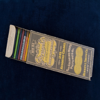

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A box of crayons was made by Binney & Smith.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights a pack of Crayola Crayons from 1903, celebrating a beloved back-to-school tradition. Invented by cousins Edwin Binney and C. Harold Smith, the crayons were crafted using paraffin wax and nontoxic pigments, making them safe and durable for young artists. The name "Crayola," created by Alice Binney, combines the French word for chalk, "craie," with "oleaginous," referring to its waxy texture. This particular set, aimed at budding artists, features 28 vibrant colors, including celestial blue and rose pink, and is one of the earliest produced. The packaging, labeled 

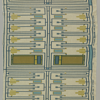

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. In this image we can see a design.
==> Ground truth answer: This exhibit features a striking piece designed by the renowned American architect Frank Lloyd Wright, who lived from 1867 to 1959. The textile, produced by F. Schumacher & Co., a New York-based manufacturer established in 1889, showcases a captivating geometric pattern composed of rectangular blocks in shades of light blue and various olive tones, intricately connected by fine lines of darker blue against an off-white backdrop. The length of the printed linen measures 120 by 57.5 cm (47 1/4 by 22 5/8 inches), with a repeat height of 63.5 cm (25 inches). Additionally, five alternate colorways of this design are affixed to the upper ba

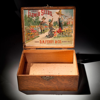

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box.
==> Ground truth answer: This exhibit features an antique seed box from the late 19th century, specifically from the renowned D.M. Ferry & Co., and is part of the Smithsonian's celebration of National Garden Month. In the 1800s, seed packets were commonly stored in decorative wooden boxes that showcased vibrant labels from seed companies, serving as effective marketing tools on general store counters. This particular seed box, which showcases the D.M. Ferry & Co. label, is significant for its association with the invention of the “commission box,” a display rack that revolutionized retail presentation. Acquired by the Smithsonian in 1986, this artifact highlights the evolution of advertisi

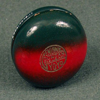

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a red and black ball.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History highlights the captivating story of the yo-yo, a toy that gained immense popularity in America thanks to Chicago businessman Donald F. Duncan Sr. In 1928, Duncan discovered the yo-yo during a business trip to San Francisco, where it was being sold by Pedro Flores, a Filipino immigrant. Flores had begun manufacturing the toy, which he named “yo-yo,” meaning “come-come” in Tagalog. By early 1929, he had established his own company and produced over 100,000 wooden yo-yos, recognizing the need for demonstrations to attract buyers. Duncan, an astute entrepreneur, quickly saw the toy's potentia

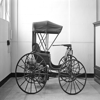

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a black and white image. In the center of the image we can see a vehicle. In the background of the image we can see the wall.
==> Ground truth answer: The exhibit features the 1893-94 Duryea automobile, recognized as one of the earliest American-made vehicles. On September 21, 1893, Frank Duryea conducted a road test of this innovative automobile, which was essentially a second-hand carriage outfitted with a gasoline engine, in Springfield, Massachusetts. In 1896, Frank and his brother Charles, along with financial partners, established the Duryea Motor Wagon Company, marking it as the first American enterprise to manufacture and sell automobiles. This particular model is powered by a one-cylinder, four

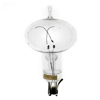

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a bulb.
==> Ground truth answer: This exhibit showcases the Edison Light Bulb, which dates back to 1879 and represents a pivotal moment in the history of innovation. Thomas Edison utilized this carbon-filament bulb during the inaugural public demonstration of his groundbreaking invention—the light bulb, recognized as the first viable electric incandescent lamp. The mechanism of the bulb involves an electrical current flowing through a metal filament wire, which heats up to an intense temperature, ultimately producing light. To safeguard the hot filament from oxygen, the bulb is encased in glass filled with inert gas. This significant demonstration took place at Edison's laboratory in Menlo Park, New Jer

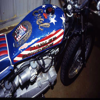

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A Harley Davidson motorcycle is covered in American flag stickers and has "Harley Davidson" on the seat.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History showcases Evel Knievel's iconic 1972 Harley-Davidson XR-750, a motorcycle synonymous with the legendary daredevil's thrilling performances. Evel Knievel, born Robert Craig Knievel, captivated audiences with his death-defying stunts, which often resulted in numerous injuries, including 35 to 40 broken bones throughout his career. His televised daredevil shows, beginning in 1965, featured spectacular jumps over rows of vehicles, including cars, trucks, and buses. The XR-750, constructed from steel, aluminum, and fibe

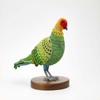

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy of a bird.
==> Ground truth answer: The exhibit features Laurel Roth Hope's intriguing work titled “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece cleverly employs humor to highlight the grave issue of species extinction. Through her “Biodiversity Reclamation Suits,” Hope enables common rock pigeons to don the guise of extinct North American birds, symbolically addressing the loss of biodiversity. Utilizing traditional crafting techniques such as carving, embroidery, crochet, and collage, she transforms everyday materials into striking animal sculptures that evoke both playfulness and a deeper emotional response. 

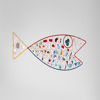

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting.
==> Ground truth answer: This exhibit features "Fish," a captivating work by renowned artist Alexander Calder, created in 1945 and housed at the Hirshhorn Museum and Sculpture Garden in Washington, D.C. Calder, who was born into a family of artists and initially trained as a mechanical engineer, transitioned to art after working as a freelance illustrator. His journey took him to Paris, where he became inspired by avant-garde movements and began crafting his signature wire sculptures, often referred to as “drawings in space.” Influenced by the minimalist aesthetic of Piet Mondrian, Calder pioneered the concept of “mobiles” in 1931—kinetic sculptures that move with air currents. He also creat

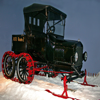

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a vehicle on the snow.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a 1921 Ford Model T equipped with a unique snow attachment, highlighting the ingenuity of early 20th-century rural mail carriers. As these carriers transitioned from horse-drawn sleds to automobiles, they faced challenges navigating deep snow. In response, Virgil White innovated by converting cars into snowmobiles, replacing front tires with skis and rear tires with caterpillar treads. His invention, dubbed the Snowbird, provided a cost-effective solution for winter deliveries, eliminating the need for horses. Initially, White's prototype was based on a Buick Model G, but as th

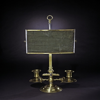

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a candle stand.
==> Ground truth answer: This exhibit showcases a significant artifact linked to George Washington, specifically a brass candle stand believed to have been used by him while composing his Farewell Address in 1796. After serving two terms as president, Washington chose to retire to Mount Vernon, where he penned his final thoughts for the nation, urging unity among Americans amidst emerging political factions. His Farewell Address was first published in The American Daily Advertiser and has since been commemorated annually by the United States Senate, where a member reads it aloud in honor of Washington's birthday. The candle stand, featuring a green silk-lined reflector designed to enhanc

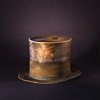

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a hat.
==> Ground truth answer: This exhibit features President Abraham Lincoln's iconic top hat, housed at the Smithsonian's National Museum of American History. Acquired from Washington hat maker J.Y. Davis, this hat stands as a symbol of Lincoln's stature, both physically at 6'4” and in his leadership. Notably, a black silk mourning band adorns the hat, honoring the memory of his son Willie, who passed away in 1862. While the exact date of acquisition remains unknown, the hat was last worn by Lincoln on the fateful night of April 14, 1865, as he headed to Ford's Theatre. Following Lincoln's assassination, the War Department safeguarded the hat along with other belongings left behind, later transferri

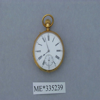

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a pocket watch that is gold.
==> Ground truth answer: This exhibit at the Smithsonian's National Museum of American History features a remarkable timepiece belonging to Helen Keller, who was born on June 27, 1880. Keller, a pivotal figure in advocating for women's suffrage and workers' rights, faced significant challenges after losing her sight and hearing due to illness at a young age. Her breakthrough came with the help of Anne Sullivan, who taught her to communicate. The Swiss-made "touch watch," gifted to Keller by John Hitz in 1892, is designed with pins around its edge to indicate the hours, allowing Keller to tell time even in darkness. This unique watch symbolizes Keller's extraordinary journey 

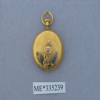

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A gold pocket watch is on display with a small card reading ME 335239.
==> Ground truth answer: This exhibit showcases an extraordinary pocket watch that once belonged to Helen Keller, who was born on June 27, 1880. Keller, known for her advocacy for women's rights and disability rights, faced immense challenges after becoming deaf and blind at a young age. Her life changed dramatically when she met Anne Sullivan, who taught her to communicate. The watch, presented to Keller by John Hitz in 1892, features a unique design with pins around the case that allow the wearer to feel the time, making it particularly suitable for someone who could not see. Keller cherished this watch throughout her l

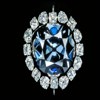

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a diamond.
==> Ground truth answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a primary gem that weighs an impressive 45.52 carats. The diamond, characterized by its dark gray-blue hue, is cut in a modified antique cushion style, which enhances its unique visual appeal. Originating from India, this exquisite piece is part of the Mineral Sciences collection, specifically within the Gems category at the National Museum of Natural History. The necklace is cataloged under the USNM number NMNH G3551-00 and is a singular specimen in this exhibit, last modified on September 26, 2022. For more detailed information, you can access the original record through the provi

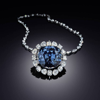

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This necklace contains the largest blue diamond in the world.
==> Ground truth answer: This exhibit showcases a remarkable diamond necklace by Cartier, Inc., featuring a single primary gem that weighs 45.52 carats. The diamond is distinguished by its dark gray-blue color and is elegantly cut in a modified antique cushion shape, which adds to its vintage charm. Sourced from India, this necklace is a highlight of the Mineral Sciences collection at the National Museum of Natural History, categorized under Gems. The record for this exquisite piece is identified as NMNH G3551-00 and was last updated on September 26, 2022. For further details, you can explore the original record linked here.
==> S

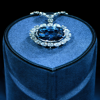

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a necklace on the stand.
==> Ground truth answer: On display is a captivating diamond necklace by Cartier, Inc., featuring a single, striking primary gem that weighs 45.52 carats. This diamond exhibits a dark gray-blue coloration and is expertly cut in a modified antique cushion style, making it a true work of art. The necklace hails from India and is part of the Mineral Sciences department's Gems collection at the National Museum of Natural History. It is cataloged under the USNM number NMNH G3551-00, with the last modification recorded on September 26, 2022. For more in-depth information, you can follow the link to the original rec

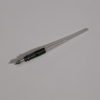

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a pen.
==> Ground truth answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2 of that year. Part of the Smithsonian's National Museum of African American History and Culture collection, this particular pen was among over 70 identical pens distributed to key figures in the Civil Rights Movement. The journey to the enactment of this landmark legislation was fraught with challenges, initially introduced by President John F. Kennedy before his tragic assassination in November 1963. The bill's fate then rested with President Johnson, who oversaw lengthy public hearings and debat

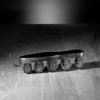

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a toy on the surface.
==> Ground truth answer: This exhibit features the Volito, an innovative inline skate crafted in 1823 by Robert John Tyers. As athletes prepare for the 2014 Winter Olympics, it's intriguing to consider how skaters of the 19th century maintained their skills without the luxury of indoor rinks. The Volito is distinguished by its wooden sole, a single row of five wooden wheels, and a unique curved iron bar at the front, which functioned as a basic brake. What truly set this skate apart was its unequal wheel sizes—larger in the center and smaller at the ends—allowing skaters to navigate turns with greater ease. This remarkable design reflects the ingenuity of early spo

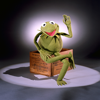

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a toy.
==> Ground truth answer: This exhibit showcases Kermit the Frog, a beloved character created by Jim Henson, who has become an iconic figure in children's television. Kermit, a vibrant green puppet, first appeared in 1955 on the show "Sam and Friends" and has since been the star of "The Muppet Show" and a regular on "Sesame Street." Known for his calm demeanor amidst chaos, Kermit is famous for his poignant song “Bein' Green,” which reflects on the challenges of his color while ultimately celebrating his identity. The puppet is crafted from various materials, including synthetic fiber, felt, and plastic, and measures approximately 27 inches in height. This piece, gifted by Jim Henson Productions, 

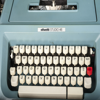

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A close up of the keyboard on a Olivetti Studio 46 typewriter.
==> Ground truth answer: This exhibit features the typewriter of Octavia Estelle Butler (1947–2006), a celebrated author in the realm of science fiction. Butler is renowned for her impactful works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the thought-provoking novels Parable of the Sower and Parable of the Talents, along with her acclaimed short story collection, Bloodchild and Other Stories. Her writing uniquely blended elements of African American history with speculative futures and alien psychology, establishing a genre known as Afrofuturism. By centering characters

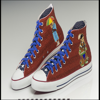

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: These are the shoes which are in brown color.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri Greeves in 2004. The artwork, which takes the form of sneakers, is a unique blend of traditional and contemporary materials, incorporating cotton canvas, glass beads, and commercial rubber. Measuring 33 x 11 x 15 cm, this piece exemplifies Greeves' innovative approach, showcasing overlay beadwork that reflects the rich cultural heritage of the Kiowa people. Acquired by the National Museum of the American Indian from Thirteen Moons Gallery in Santa Fe, New Mexico, this work is part of a broader collection that highlights the intersection of indigenous

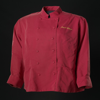

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A red chef's jacket with gold embroidery that reads Leak Chine.
==> Ground truth answer: This exhibit showcases a significant collection from the Smithsonian's National Museum of African American History and Culture, featuring a gift from Dooky Chase's Restaurant and renowned Chef Leah Chase. Celebrated for her assertion that “we changed the world over a bowl of gumbo,” Chase played a pivotal role in the civil rights movement by hosting strategy meetings at her restaurant. Known as "The Queen of Creole Cuisine," she elevated New Orleans Creole cooking to global prominence. Alongside her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop established by her mother-in-law in the 

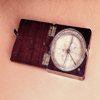

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a compass.
==> Ground truth answer: This exhibit showcases a remarkable silver-plated pocket compass that dates back to around 1804, purchased by Meriwether Lewis in preparation for the historic Lewis and Clark Expedition. Crafted by Philadelphia instrument maker Thomas Whitney, the compass features a mahogany box, a brass rim graduated in degrees, a paper dial, and two brass sight vanes, all housed in a leather carrying case. While it remains uncertain whether Lewis intended the compass for himself or as a gift for his expedition partner, William Clark, it served as a vital navigational tool during their journey. Under President Thomas Jefferson's directive, the Corps of Discovery embarked on their mis

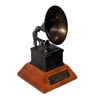

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a trophy.
==> Ground truth answer: This exhibit showcases Bob Newhart's 1960 Grammy Award, a significant artifact from the celebrated comedian's illustrious career. Born on September 5, 1929, in Oak Park, Illinois, Newhart has entertained audiences for over sixty years with his signature deadpan style, cleverly critiquing social norms and the absurdities of American life. His groundbreaking comedy album, The Button-Down Mind of Bob Newhart, made history by becoming the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, making him the only comedian to win a Grammy for Best New Artist. Newhart's influence extended into television, where he starred in iconic 

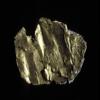

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a piece of gold.
==> Ground truth answer: This exhibit features a remarkable gold nugget from 1848, housed at the Smithsonian's National Museum of American History. Regarded as the first gold piece discovered at Sutter's Mill in California, this nugget played a pivotal role in sparking the infamous gold rush. On January 24, 1848, while overseeing the construction of a sawmill, James Marshall noticed a glimmer in the water and retrieved what he identified as a thin scale of pure gold. Following this discovery, Marshall presented the scale to Capt. Joseph L. Folsom, who documented it as the first gold found in Northern California. By August of that year, this nugget, along with other samples, reached Wash

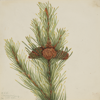

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see a plant with a flower.
==> Ground truth answer: This exhibit showcases the exquisite watercolor work of Mary Vaux Walcott, particularly her piece titled "Lodgepole Pine (Pinus Contorta murrayana)" created in 1921. Measuring 10 x 7 inches, this artwork is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began when a botanist encouraged her to paint a rare blooming arnica. Her marriage to Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914 led to summers spent in the Canadian Rockies, where she produced hundreds of watercolor studies of local flora. From 1925 to 1929, a sel

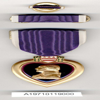

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The purple ribbon is for the military and has a gold frame with a picture of a man.
==> Ground truth answer: This exhibit features the esteemed United States Purple Heart, a distinguished military decoration awarded to those wounded or killed while serving in the U.S. armed forces. The medal is crafted in a striking gold heart shape, showcasing a profile relief of George Washington at its center, set against a rich purple enamel background. Above Washington's bust, the medal is adorned with a shield displaying his family coat of arms. The reverse side bears the embossed inscription "FOR MILITARY MERIT," highlighting the medal's significance. It is suspended from a silk purple ribbon, edged with a white stripe, 

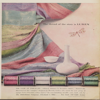

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a poster. On the poster we can see a cloth, vase, threads and some text.
==> Ground truth answer: This exhibit, titled "The Thread of the Story Is Lurex: The Look of Porcelain," showcases the work of renowned American textile designer Dorothy Liebes, who significantly influenced various design disciplines from the 1930s to the 1960s. Known for her vibrant colors and rich textures, Liebes developed a distinctive style that became synonymous with the modern American aesthetic, referred to as the “Liebes Look.” Her collaborations with notable architects and designers, such as Frank Lloyd Wright and Raymond Loewy, as well as fashion icons like Pauline Trigère, resulted in some of the most i

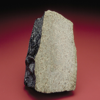

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a rock.
==> Ground truth answer: This exhibit features a fragment of the Nakhla meteorite, which is significant as one of the thirty-four meteorites believed to have originated from Mars. The Nakhla meteorite fell to Earth on June 28, 1911, around 9 a.m. in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in approximately 40 pieces, weighing a total of 22 pounds. These fragments were found buried up to a meter deep in the ground. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a 480-gram piece to its collection, totaling 650 grams of Nakhla fragments by the 1970s. The Nakhlites, named after Nakhla, are igneous rocks rich in augite, fo

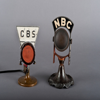

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: There are two microphones. One microphone has the letters "NBC" on it. The other microphone has the letters "CBS" on it.
==> Ground truth answer: This exhibit features a significant artifact from the era of President Franklin D. Roosevelt's "Fireside Chats," a series of informal radio addresses he delivered to the American public starting on March 12, 1933. With the nation grappling with the Great Depression, Roosevelt's ability to communicate directly with citizens through radio became a vital tool for shaping public opinion and providing reassurance. The exhibit highlights an RCA Type 50-A microphone, adorned with the National Broadcasting Company logos, which was used during these broadcasts. Acquired by the

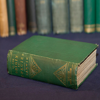

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A green book with gold lettering sits on a blue cloth.
==> Ground truth answer: This exhibit showcases "On the Origin of Species" by Charles Darwin, published in 1859, and is part of the Smithsonian Institution Libraries collection. It commemorates the May 11, 1820, anniversary of the HMS Beagle's launch, the vessel that carried Darwin on his pivotal scientific journey. The Beagle was launched from the Woolwich Dockyard in London and underwent several adaptations before embarking on its second survey voyage on December 27, 1831. Darwin, a young naturalist, joined the crew to provide geological insights, and his extensive research during the five-year expedition to South America and the Galápagos Islands laid th

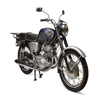

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a black color motor bike.
==> Ground truth answer: This exhibit features Robert M. Pirsig's iconic 1966 Honda Super Hawk motorcycle, prominently showcased at the Smithsonian's National Museum of American History. This motorcycle is not just a vehicle; it is a symbol of the philosophical journey outlined in Pirsig's influential book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling over a million copies within its first year and igniting a cultural movement that encouraged individuals to reevaluate their relationship with technology and seek a harmonious existence. The inspiration for "Zen" arose from a tran

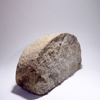

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a rock.
==> Ground truth answer: The exhibit features the Plymouth Rock Piece, a significant artifact housed at the National Museum of American History, which is believed to be linked to the landing of the Mayflower Pilgrims in 1620. According to tradition, this rock marks the site where William Bradford and his fellow settlers first arrived in Plymouth, Massachusetts. Bradford, who played a pivotal role as a leader and governor of the Plymouth Colony, is also credited with the establishment of Thanksgiving as it is celebrated in the United States today. The rock has a storied past, having been relocated in 1774 from its original position to the town square, where it unfortunately split into two halves.

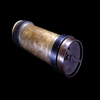

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a cylindrical object.
==> Ground truth answer: This exhibit at the Smithsonian's National Postal Museum showcases a Pneumatic Mail Container from 1953, a fascinating relic of a bygone era when cities utilized pneumatic tube systems for mail delivery. Originating in the late 1890s, these systems were ingeniously designed to transport mail through underground tubes, with each canister capable of holding up to 500 letters. The canisters, or carriers, were propelled by compressed air, allowing them to travel at speeds averaging 35 miles per hour. At the height of their operation, these systems facilitated the movement of an astounding 6 million pieces of mail daily, with five carriers dispatched every minut

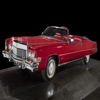

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a car on the floor.
==> Ground truth answer: The "Rock 'n' Roll Ride" exhibit at the Smithsonian's National Museum of African American History and Culture showcases a remarkable piece of musical history: Chuck Berry's striking red 1973 Cadillac Eldorado. This vehicle is prominently featured in the museum's "Musical Crossroads" exhibition. The Cadillac was a cherished part of Berry's personal collection and gained fame during the filming of the 1987 documentary "Hail! Hail! Rock 'n' Roll," directed by Taylor Hackford. The film captures the essence of two concerts held in 1986 to honor Berry's 60th birthday, and it features a memorable moment when Berry drove this very Cadillac onto the s

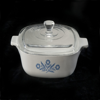

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: White pot with a blue flower design by Pyrex.
==> Ground truth answer: This exhibit features a quintessential kitchen item often associated with holiday gatherings—a white casserole dish made by CorningWare in 1965. Adorned with the iconic blue cornflower motif, this dish represents a blend of innovation and tradition. Originally created for military use during World War II, CorningWare's Pyroceram material later emerged as an ideal choice for bakeware, thanks to its ability to endure rapid temperature shifts and resist stains and odors. Its versatility allowed it to transition seamlessly from cooking to freezing to serving, making it a beloved tool in many kitchens. In the 1990s, the brand 

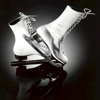

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a pair of ice skates.
==> Ground truth answer: This exhibit features the autographed ice skates of Sonja Henie, a pioneering figure in women's figure skating, dating back to around 1945. Henie, a Norwegian skater, revolutionized the sport in the late 1920s and 1930s by introducing white leather skates, a significant departure from the traditional black skates. Her enchanting performances earned her the first of ten consecutive world titles in 1927, where she captivated audiences with her innovative dance style. Henie's influence extended beyond the rink; she was the first to blend choreography with figure skating and popularized the short skirt and white skate aesthetic that remains fas

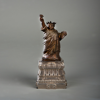

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a statue of liberty.
==> Ground truth answer: This exhibit features one of the earliest models of the Statue of Liberty, often referred to as the American Committee Model. Crafted in the United States, this statuette was produced in large quantities, with tens of thousands sold to raise funds for the construction of the statue's pedestal in New York Harbor. The design, created by French sculptor Frédéric-Auguste Bartholdi, was made available in both six-inch and twelve-inch sizes, with a national newspaper campaign promoting them at one dollar and five dollars respectively. Richard Butler, a rubber manufacturer from New York, led the American Committee overseeing the production of these models. This ini

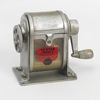

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a picture of a machine.
==> Ground truth answer: The exhibit features the Dexter Model 3 Pencil Sharpener, crafted around 1920 by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. This charming artifact, made from metal, cellulose, and painted wood, measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.). A gift from Lucy Commoner, it holds a significant place in the Cooper Hewitt, Smithsonian Design Museum collection, although it is not currently on display. As the back-to-school season approaches, this sharpener evokes nostalgia for many, reminiscent of countless school days. The Dexter Model 3 was an evolution of earlier designs, featuring a rotating wheel with calibrated open

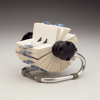

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A round item with cards on it with the number 1 on it.
==> Ground truth answer: This exhibit features the iconic Rolodex Open Rotary Card File, a quintessential office supply that revolutionized the way people organized their business contacts before the advent of digital technology. Manufactured by the Rolodex Corporation in the USA, this particular model is crafted from bent tubular metal, molded plastic, rubber, and paper, measuring 18 x 18 x 16.5 cm. The Rolodex operates on a cylindrical design, allowing users to easily flip through A-Z index cards to find contact information. Despite the rise of smartphones and computers, the Rolodex remains a relevant tool in modern workplaces, symboli

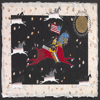

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a painting.
==> Ground truth answer: The exhibit features the "Lakota Horse Mask," created in 2008 by Jim Yellowhawk, a member of the Cheyenne River Lakota tribe. This striking piece, which utilizes acrylic on paper and gold leaf, symbolizes the profound relationship between American Indians and horses, which many tribes refer to as the Horse Nation. Horses were not only allies in times of peace but also played a vital role during conflicts, deeply influencing the cultural landscape of various tribes. Interestingly, horses first emerged in the Americas over 40 million years ago, later becoming extinct before being reintroduced by Columbus in 1493. Today, this artwork is part of the coll

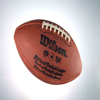

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a football.
==> Ground truth answer: This exhibit features the iconic Wilson Duke football, which has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was specifically used during Super Bowl XIV, held at the Rose Bowl in Pasadena, California, on January 20, 1980. In this thrilling game, the Pittsburgh Steelers triumphed over the Los Angeles Rams with a score of 31-19, marking the Steelers' fourth Super Bowl victory. Notably, it was also the second consecutive year that quarterback Terry Bradshaw earned the Most Valuable Player award. The Wilson Duke football, known for its premium leather and durable construction, was introduced by Wilson Spo

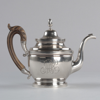

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a teapot with a silver lid.
==> Ground truth answer: This exhibit features a remarkable silver teapot created by American artisan Peter Bentzon, dating from approximately 1817 to 1829. The teapot showcases an elegant oval vase shape, supported by a spreading pedestal foot. Its design includes a gracefully curved spout, which is topped with an incised patera, and a scroll handle adorned with wooden leaf caps. The hinged domed lid is finished with an acorn finial, adding to its aesthetic appeal. Notably, the piece bears the scripted monogram "MC" engraved on its side, alongside the name "Rebecca Dawson" inscribed along the bottom rim. This exquisite object is part of the National Museum of African America

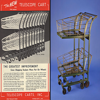

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a poster. On the left side there is a picture of a trolley. On the right side there is a picture of a trolley.
==> Ground truth answer: The exhibit at the National Museum of American History features the innovative Telescoping Shopping Cart, designed by Orla E. Watson in 1946. This clever invention, first introduced in 1947 at Floyd's Super Market in Kansas City, Missouri, revolutionized the way consumers shop by allowing carts to nest together for efficient storage. Watson asserted that these new carts utilized only one-fifth of the space of traditional carts when parked, making them a practical solution for busy shoppers. This display is part of the Smithsonian's inaugural major exhibition on food his

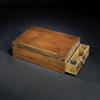

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a wooden box with a lid.
==> Ground truth answer: This exhibit showcases the portable writing desk designed by Thomas Jefferson, which he used to draft the Declaration of Independence in 1776. The desk features a hinged writing board and a locking drawer for storing essential writing materials such as papers, pens, and an inkwell. During the summer of 1776, as members of the Second Continental Congress prepared to declare independence from Great Britain, Jefferson, a Virginia delegate, was tasked with drafting this pivotal document. He later noted that the declaration was meant to reflect the collective American sentiment rather than being an original work. On July 4, 1776, the Continental Congress adop

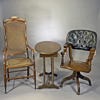

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: Three old fashioned chairs are on display.
==> Ground truth answer: This exhibit focuses on a pivotal moment in American history, specifically the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. It showcases the chair used by General Ulysses S. Grant during his negotiations with General Robert E. Lee, marking the effective conclusion of the Civil War. The exhibit highlights how Grant, seated in this chair, drafted and signed the surrender terms, a significant act that symbolized the end of hostilities. Following the surrender, Union officers took pieces of furniture as mementos, with Grant's chair and the table being notable examples. These artifacts were eventually donated to the 

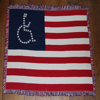

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: On the floor is a blanket with the American flag on it.
==> Ground truth answer: This exhibit features a unique lap blanket that has been hand-altered to incorporate the universal access symbol, represented by stitched stars, reflecting the ideals of freedom and independence associated with the American flag. Created by advocates from the American Disabled for Attendant Programs Today (ADAPT), this piece signifies the ongoing struggle for civil rights among individuals with disabilities. Founded in 1983 in Denver, ADAPT emerged from the disability rights movement, which gained momentum after World War II as individuals with disabilities formed communities and advocated for their rights. The lap blanket serves a

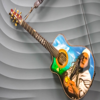

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: A guitar is hung up on the wall. It has a VH logo on the body and a picture of a man holding a microphone on the face.
==> Ground truth answer: This exhibit showcases the guitar of Carlos Vives, a renowned Colombian singer and Grammy Award winner celebrated for his contributions to the vallenato music genre. Vallenato, originating from Colombia's Atlantic coast, blends European instruments like the accordion with rich, poetic lyrics and the traditional rhythms of the Arhuaco indigenous people. Historically, vallenato was performed by rural workers and cowboys, remaining largely within local communities until its revitalization in the 1990s by artists like Vives, who infused it with pop and rock elements. This t

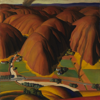

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a painting. In this image we can see trees, houses, grass, road, hills and sky.
==> Ground truth answer: This exhibition features a captivating painting by Ross Dickinson, a talented artist who thrived during the Great Depression. Created while he was part of the Public Works of Art Project, the artwork vividly portrays California's Central Valley, showcasing lush green fields alongside a small river, all framed by stark, arid hills. The scene evokes the promised land sought by many families fleeing the Dust Bowl, yet Dickinson introduces an unsettling element—a small controlled fire in the foreground and a larger plume of smoke rising from the distant hills, hinting at the ever-present threat of wildfi

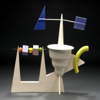

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This is a sculpture.
==> Ground truth answer: This exhibit features the imaginative work of artist Peter Shire, born in Los Angeles in 1947. Notably, Shire's teapots, particularly the Weathervane Teapot, are vibrant constructions made from clay slabs, showcasing a playful arrangement of three-dimensional squares, balls, squiggly rods, and hollow tubes. Shire aimed to challenge conventional notions of "tea-time," making it an experience that is inclusive and accessible to everyone. The design of this teapot invites interaction, prompting viewers to ponder how to hold it for pouring, or whether it is even functional as a teapot. After 1985, Shire shifted his focus from creating clay teapots to furniture design. A

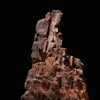

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: In this image we can see a wooden object.
==> Ground truth answer: The exhibit features the Spotsylvania tree stump, a poignant relic from the Civil War, dating back to 1864–65, located at the Smithsonian's National Museum of American History. This tree, once a majestic oak, stood in a serene meadow near Spotsylvania Court House, Virginia, until May 12, 1864, when it became a silent witness to the brutal conflict between Confederate forces and the Union's Second Corps. The area, now known as the Bloody Angle, transformed dramatically over the course of a single day, as the fierce combat led to approximately 31,000 casualties. The tree stump bears the scars of war, with several Minié balls still lodged within it

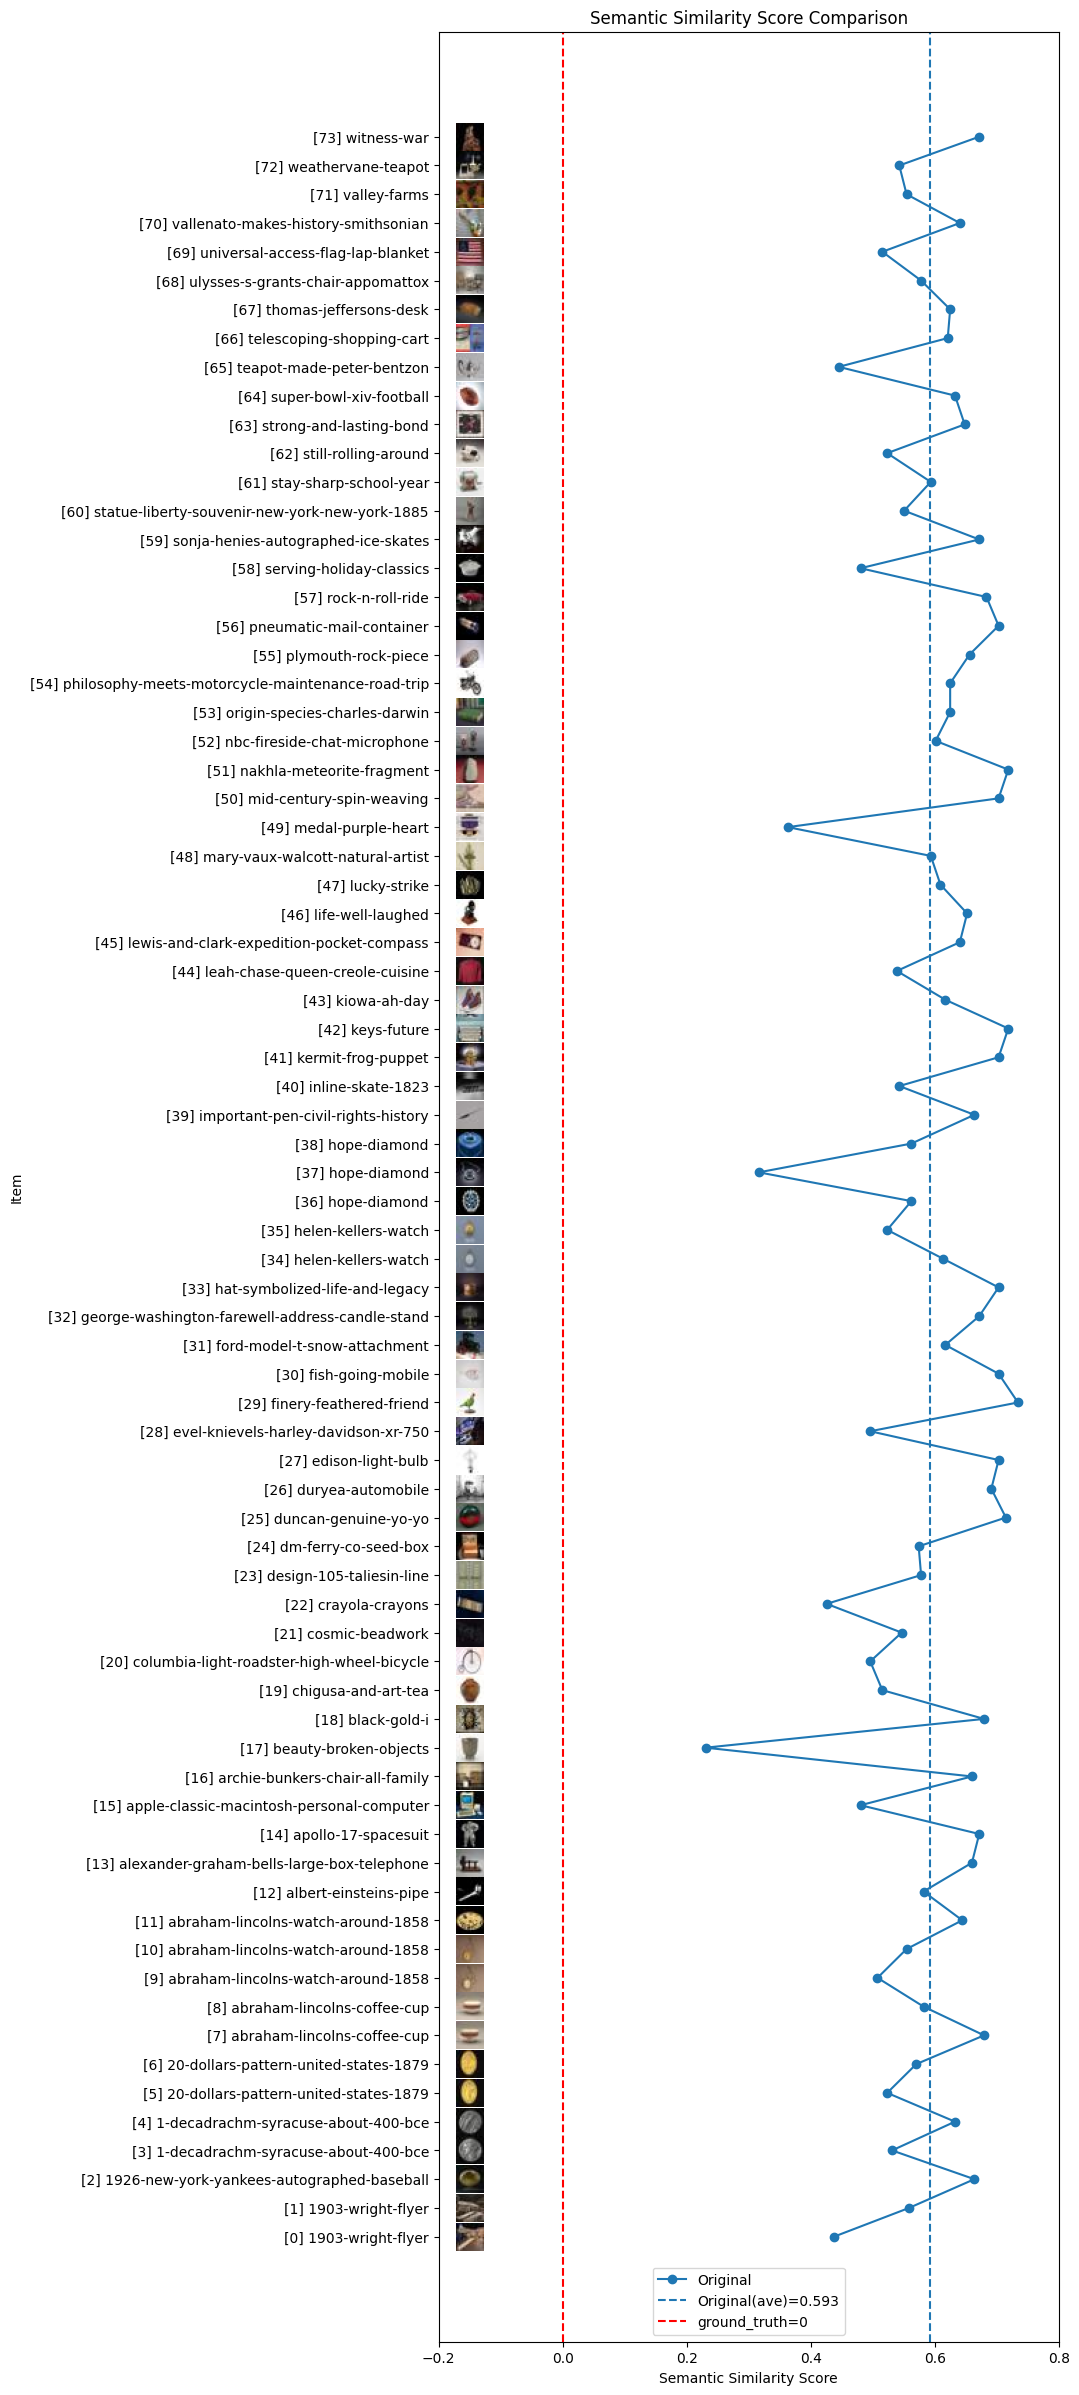

In [5]:
# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(base_model, processor, dataset['test'], './results/inference_results/inference_results_before_finetuning.csv', 3) 
# Plot similarity scores from the inference CSV file, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv')], 
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_before_finetuning.jpg')

---
# **Step 3: Training**

## 3.1 Add a Custom Padding Token

In [6]:
# Set up pad token (<pad>) in the processor
my_utils.setup_pad_token_in_processor(processor)
# Set up pad token (<pad>) in the base model
my_utils.setup_pad_token_in_model(base_model, processor)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.


## 3.2 Create a LoRA Adapter

In [7]:
#create lora adapter with rank=8 and lora_alpha=64
lora_model = my_utils.create_lora_adapter(base_model, 8, 64)
my_utils.print_model_info_to_file(lora_model, './results/model_info/lora_model_info.txt')
my_utils.print_model_parameters_to_file(lora_model, './results/model_info/lora_model_parameters.txt')

==> Creating LoRA adapter...
==> Printing model info...
==> Model type: PeftModelForCausalLM
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/lora_model_info.txt.
==> Printing model parameters...
base_model.model.model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.weight (663552, torch.uint8, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.k_proj.bias (1152, torch.bfloat16, cuda, False)
base_model.model.model.vision_model.encoder.layers.0.self_attn.v_proj.weight (663552, torch.uint8, cuda, False)
base_m

## 3.3 Set Up the Trainer

In [8]:
custom_callback = my_utils.CustomCallback()  # Optional: Custom callback to report VRAM usage during the first training step
trainer = my_utils.setup_trainer(lora_model, processor, dataset, my_utils.collate_fn, epoch_num=3, batch_size=3, callbacks=[custom_callback])

Using auto half precision backend


==> Setting up trainer...


## 3.4 Train the Model

In [9]:
my_utils.run_training(lora_model, trainer)

==> Starting training...


Currently training with a batch size of: 3
***** Running training *****
  Num examples = 819
  Num Epochs = 3
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 819
  Number of trainable parameters = 23,326,720
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


[GPU0] Step 1: Current VRAM usage: 4.73 GB, Peak VRAM usage: 15.57 GB, Total GPU VRAM: 23.58 GB



***** Running Evaluation *****
  Num examples = 82
  Batch size = 3
Saving model checkpoint to ./results/training_checkpoints/checkpoint-41
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]

***** Running Evaluation *****
  Num examples = 82
  Batch size = 3
Saving model checkpoint to ./results/training_checkpoints/checkpoint-82
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint

---
# **Step 4: Post-Training**

## 4.1 Restart Kernel for a Clean Environment

## 4.2 Load the Fine-Tuned Model from a Checkpoint  

After training, we load the fine-tuned model using the checkpoint with the minimum loss. This fine-tuned model will be used for further inference to assess improvements in model performance.


In [1]:
# Load functions
import my_login
import my_utils
import my_utils_qlora

# Log in to the Hugging Face and Weights & Biases accounts
my_login.login_hf()
my_login.login_wandb()

# Load processor and base model
processor = my_utils.load_processor()
bnb_config = my_utils_qlora.create_quantization_config()
base_model = my_utils.load_model(quantization_config=bnb_config)

# Set up pad token (<pad>) in the processor and in the base model
my_utils.setup_pad_token_in_processor(processor)
my_utils.setup_pad_token_in_model(base_model, processor)

# Load LoRA adapter from a checkpoint with the minimum loss
lora_model = my_utils.load_lora_adapter_from_checkpoint(base_model, './results/training_checkpoints/checkpoint-533')


==> Logging in to Hugging Face...
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
==> Logging in to Weights & Biases...


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xugefu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


==> Loading processor...


Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


==> Creating Quantization Configuration...
==> Loading model...


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Setting up pad token (<pad>) in processor...
==> [Original] Regular token count: 32000, regular + special token count: 32003, pad token in tokenizer: <unk>
==> Adding new pad token: <pad>
==> [Updated] Regular token count: 32000, regular + special token count: 32004, pad token in tokenizer: <pad>
==> Setting up pad token (<pad>) in model...
==> Configuring pad token in model.config and model.model.text_model for input sequence padding...
==> Configuring pad token in model.generation_config for output sequence padding...
==> Checking if resizing of model embeddings is needed...


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


==> Resized model embeddings from 32003 to 32004.
==> Loading LoRA adapter from checkpoint...


## 4.3 Perform Inference with the Fine-Tuned Model

==> Loading hf dataset...
==> Performing batch inference and saving results to ./results/inference_results/inference_results_after_finetuning.csv ...
==> [Batch: 1/25] Data in batch: 3
==> [Batch: 1/25][Data: 1/3] Inference for data_id: 3, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-1.jpg:


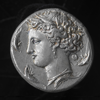

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an iconic coin from the late 5th century BCE, celebrated for its exceptional craftsmanship and high relief, created by artists like Kimon and Euinatos. The coin's allure has captivated collectors for centuries, raising questions about the techniques used by the ancient Greeks, who relied solely on manual methods to achieve such exquisite detail. Notably, this piece caught the attention of Theodore Roosevelt, a prominent reformist who felt that American coinage lacked the artistry of classical coins. His dissatisfaction sparked a movement towards enhancing the aesthetic quality of U.S. currency, culminating in his collaboration with sculptor Augustus Saint-Gaudens t

/workspace/my_utils.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, data_df], ignore_index=True)


==> [Batch: 1/25][Data: 2/3] Inference for data_id: 4, item_name: 1-decadrachm-syracuse-about-400-bce, image_name: 1-decadrachm-syracuse-about-400-bce-2.jpg:


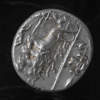

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Syracuse dekadrachm, an iconic coin from the late 5th century BCE, celebrated for its exceptional craftsmanship and high relief, which have captivated collectors for centuries. The coin's allure has intrigued historians and prompted questions about the techniques used by the ancient Greeks, who relied solely on manual methods to achieve such exquisite detail. Notably, this piece caught the attention of Theodore Roosevelt, a prominent reformist who felt that American currency lacked the artistry of classical coins. His dissatisfaction sparked a movement towards enhancing the aesthetic quality of U.S. currency, culminating in his collaboration with sculptor Augustus S

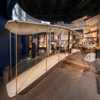

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, a groundbreaking aircraft that marked the dawn of the powered flight era. Developed by Wilbur and Orville Wright, it is powered by a 12-horsepower engine and utilizes a sprocket-and-chain system to drive two pusher propellers. Notably, the Flyer employs skids for landing, lacking traditional wheels. The brothers' four-year research and development led to the first successful flight on December 17, 1903, at Kitty Hawk, North Carolina, where Orville piloted the aircraft for 12 seconds over a distance of 36 meters (120 feet). The Flyer is constructed from a variety of materials, including wood, metal, and glass, and is a testament to the Wright brothers' innovative appr

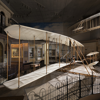

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1903 Wright Flyer, a groundbreaking aircraft that marked the dawn of the powered flight era. Developed by Wilbur and Orville Wright, it is powered by a 12-horsepower engine and utilizes a sprocket-and-chain transmission to drive two pusher propellers. Notably, the Flyer employs skids for landing, lacking traditional wheels. Its historic first flight occurred on December 17, 1903, at Kitty Hawk, North Carolina, where Orville piloted the aircraft for 12 seconds over a distance of 36 meters (120 feet). The Wright brothers' research over four years led to crucial advancements in aeronautical engineering, including the use of wind tunnels for design testing and the innov

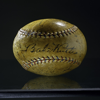

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an autographed baseball from the legendary 1926 New York Yankees, signed by baseball legends Babe Ruth and Lou Gehrig. Ruth, a celebrated Hall of Famer, and Gehrig, known for his resilience during his battle with ALS, are both pivotal figures in baseball history. The baseball, made from high-quality materials like cork, wool, and horsehide, measures 3 inches in diameter. Although not currently on display, this significant artifact is part of the National Museum of American History's collection, generously donated by the Elliot Spencer family through Brad Spencer. This piece represents a rich history of sports and leisure in America.
==> Ground truth answer: This exhibit features a remarkab

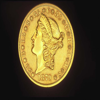

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable gold coin from the United States Mint in Philadelphia, dating back to 1879, under the reference number Judd 1643. The coin is a striking example of American coinage, showcasing a Liberty head on the obverse and an eagle, with the Latin motto DEO EST GLORIA replacing the usual IN GOD WE TRUST. This design was part of a broader effort to enhance the competitiveness of American currency in global markets, paralleling the creation of the four-dollar gold coin known as the Stella. Only nine of these gold pieces are known to exist, including the one on display. While this particular piece is currently not on view, it is an important part of the National Numismatic Collection, showcasin

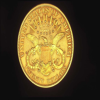

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable gold coin from the United States Mint in Philadelphia, dating back to 1879. The coin is notable for its design, which includes Liberty's head on the obverse and an eagle, emblazoned with the Latin motto "DEO EST GLORIA," on the reverse. This coin was part of a broader effort to enhance the international appeal of American currency, paralleling the creation of the four-dollar gold coin known as the Stella. Only nine of these coins are known to exist, including the one on display. While it is currently not on view, it is an important part of the National Numismatic Collection, showcasing the evolution of U.S. currency.
==> Ground truth answer: This exhibit hi

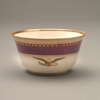

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary artifact: Abraham Lincoln's coffee cup, which dates back to 1887. It was left behind by Lincoln on the evening of Good Friday, April 14, 1865, just before he attended Ford's Theatre for the last time. A White House servant preserved the cup as a relic of that somber evening. Years later, Capt. D.W. Taylor gifted the cup to Robert Todd Lincoln, the eldest son of Abraham Lincoln, who valued it as a family heirloom. The cup is crafted from ceramic and features a striking purple color with white and gold trim, measuring approximately 3 1/4 inches in height. Donated to the Smithsonian's National Museum of American History by Lincoln Isham, Lincoln's great-grandson, in 1958, thi

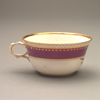

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Abraham Lincoln's coffee cup, a significant artifact from a pivotal moment in American history. On the evening of Good Friday, April 14, 1865, President Lincoln left this cup on a windowsill as he prepared to attend Ford's Theatre for the last time. Noticing this, a White House servant preserved the cup as a keepsake of that tragic night. In 1887, Capt. D.W. Taylor gifted the cup to Robert Todd Lincoln, the eldest son of Lincoln, who cherished it as a family heirloom. The cup is made of ceramic and features a striking purple color with white and gold trim, measuring approximately 3 1/4 inches in height. Donated to the Smithsonian's National Museum of American History by

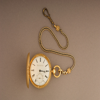

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that once belonged to President Abraham Lincoln, purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not known for his vanity, this watch served as a testament to his success in his legal career. The watch's movement was crafted in Liverpool, a renowned watchmaking city, and its case was made by an unknown American manufacturer. The watch is notable for its top-quality movement, which can keep time with remarkable accuracy when properly maintained. It is also equipped with a 18K gold case, showcasing the high standards of craftsmanship at the time. A fascinating aspect of this watch is the hidden message engraved b

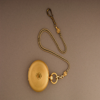

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that once belonged to Abraham Lincoln, purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not known for his vanity, this watch served as a testament to his success in his legal career. The watch's movement was crafted in Liverpool, a renowned watchmaking city, and its case was made by an unknown American manufacturer. The watch is notable for its top-quality movement, which can keep time with remarkable accuracy when properly maintained. It also features a 18K gold case, showcasing the high standards of craftsmanship at the time. A significant event occurred on April 12, 1861, the day of Lincol

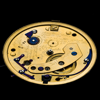

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that once belonged to President Abraham Lincoln, purchased in the 1850s from jeweler George Chatterton in Springfield, Illinois. While Lincoln was not known for his vanity, this watch was a treasured possession, as evidenced by the engraved message left by watchmaker Jonathan Dillon during the attack on Fort Sumter on May 12, 1861. Dillon's inscription, along with that of another watchmaker, L. E. Gross, and a later inscription by a third watchmaker, J. W. Davis, provide a poignant reminder of the turbulent times. The watch was not only a personal memento for Lincoln but also a symbol of the nation's strugg

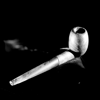

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Albert Einstein's pipe, dating back to around 1948, which serves as a fascinating artifact linked to one of history's most influential scientists. Einstein, known for his groundbreaking work in theoretical physics and a Nobel Prize laureate, is also recognized for his distinctive appearance, often including a pipe. Although he reduced his smoking later in life due to health concerns, he cherished the tactile experience of a pipe. This particular pipe shows signs of extensive use, including a hole worn into the bit, and was gifted to his friend Gina Plunguian in 1948. The Smithsonian acquired this significant piece in 1979, and it is part of a larger collection of over 1,000 artifacts displ

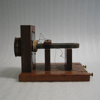

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the invention of the telephone by Alexander Graham Bell, who received the first patent for his device on March 7, 1876. Just three days later, Bell successfully transmitted his initial message to his assistant, Thomas Watson, marking a significant leap in communication technology. The exhibit includes one of the two telephones used by Bell during a demonstration between Boston and Salem on November 26, 1876. This particular telephone is distinguished by its construction, which includes an iron diaphragm and two electromagnets, and notably lacks a wooden enclosure seen in many of its contemporaries. Acquired by the Smithsonian in 1923, this artifact is part of a larger collection of nearly 

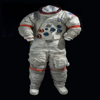

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apollo 17 spacesuit, an iconic piece of history from the final Apollo mission that landed astronauts on the moon in December 1972. The mission was launched on December 7 by a Saturn V rocket and included Commander Eugene Cernan, command module pilot Ron Evans, and lunar module pilot Harrison Schmitt, who is notable for being the only geologist to have walked on the moon. While Evans remained in orbit, Cernan and Schmitt landed the lunar module "Challenger" in the Taurus-Littrow region and conducted three moonwalks over three days, collecting 110 kilograms of lunar samples and driving a lunar rover for 35 kilometers. They also operated the lunar rover in the lunar module "Challenger" fo

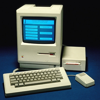

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Apple "Classic" Macintosh Personal Computer, a groundbreaking device in the history of computing that was introduced by Apple Inc. in January 1984. The Macintosh was revolutionary for its time, introducing a graphic user interface that allowed users to select programs using icons rather than the cumbersome command line. This concept was initially developed at Xerox's Palo Alto Research Center but was successfully commercialized by Apple, which famously promoted the Macintosh with a memorable Super Bowl XVIII advertisement. The computer was priced at approximately $2,500 and initially came with only 128K of RAM, leading to the release of the Macintosh 512 KB, known as "Fat Mac," in Sept

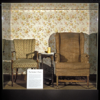

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an upholstered wing chair that holds significant historical importance as it is associated with the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. On that day, General Ulysses S. Grant and General Robert E. Lee gathered in the chair to negotiate the terms of surrender, which ultimately led to the signing of the surrender agreement. The chair, made of wood and measuring 37.5 inches in height, is a symbol of this pivotal moment in American history. Following the surrender, Union officers claimed various pieces of furniture as souvenirs, including this chair, which was later donated to Major General George Armstrong Custer's wife by General E. W. Whitaker. In 18

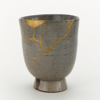

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an exquisite tea bowl from the 17th century, belonging to the White Satsuma type from Kagoshima prefecture, Japan. The bowl, made from stoneware and adorned with a clear, crackled glaze, has a compelling history marked by a break that led to its restoration through the Japanese technique of kintsugi, or golden joinery. Unlike typical restoration methods that aim to hide damage, kintsugi embraces the bowl's imperfections, using lacquer made from tree sap to repair the cracks, which is toxic in its raw state but becomes safe and durable when cured. This process not only yields a water-resistant and durable finish but also involves a meticulous process that takes several days to complete. Kin

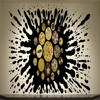

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Yinka Shonibare, a prominent artist born in London in 1962. It showcases a striking arrangement of 25 circular canvases, each varying in size, arranged over a large-scale ink splatter pattern that has been meticulously created with a template. The canvases are adorned with intricate foliate patterns painted in black and gold, using Dutch wax printed fabrics. Shonibare's recent evolution is evident, moving from small square canvases in rows to these dynamic forms that challenge traditional edges and borders. The artwork references Africa's valuable oil resources, termed "black gold," and engages with the expressive splatter techniques of Jackson Pollock, creating a playful yet t

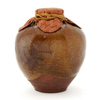

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable tea-leaf storage jar from the 17th century, belonging to the White Satsuma type from Kagoshima prefecture, Japan. The jar is crafted from stoneware and showcases a unique design with a wide, broad base and a narrow, curved neck, adorned with a decorative fabric cover. Notably, the jar's lid is adorned with an antique Chinese fabric cover, adding to its historical significance. The jar's origin story is somewhat elusive, but it is known that it was given to the tea master Yinka Shonibare in 1684 by the tea-leaf collector Teago Johnson. Shonibare's collection of tea utensils included this jar, which he used for the tea ceremony, and he later gifted it to his friend, the tea mast

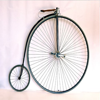

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an original 1886 Columbia Light Roadster high-wheel bicycle, a remarkable artifact from the dawn of cycling history. Manufactured by the Pope Manufacturing Co., the first company in the United States to produce bicycles, this bicycle was sold for about $135 and showcases a 53-inch front wheel with 60 spokes and an 18-inch rear wheel with 20 spokes, highlighting the variety of sizes available to cyclists at the time. The exhibit also includes a historical group photograph of early cyclists, showcasing the first organized biking tour in America, with Charles E. Pratt, the first president of the League of American Wheelmen, leading the group outside Readville, Massachusetts, in 1879. The Smit

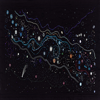

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features "Milky Way, Starry Night #2," a striking work by Gwich'in artist Margaret Nazon from Tsiigehtchic, Northwest Territories, Canada, created in 2021. Nazon's artistic expression is deeply influenced by her childhood love for astronomy, which she began to explore through her art in her 60s after being inspired by stunning images from the Hubble Space Telescope. This piece, characterized by swirling galaxies, represents a departure from traditional Gwich'in beadwork, showcasing Nazon's unique style. It is part of the "Lights Out: Recovering Our Night Sky" exhibition at the Smithsonian's National Museum of Natural History, which examines the impact of light pollution on the night sky and its sign

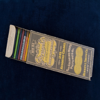

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an original pack of Crayola Crayons from 1903, celebrating the enduring legacy of these beloved art supplies. Created by Edwin Binney and C. Harold Smith, founders of Binney & Smith Co., these crayons were crafted from paraffin wax and non-toxic pigments, making them safe and accessible for children. The name "Crayola," coined by Alice Binney, is a combination of the French word for chalk and oily, aptly describing the crayons' composition. The box, marked "No. 51, Young Artists Drawing Crayons," contains 28 colors, including celestial blue and rose pink, and features a charming illustration of a girl coloring. Over the years, the crayon colors and packaging have evolved, reflecting social

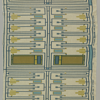

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking textile designed by the influential American architect Frank Lloyd Wright, who lived from 1867 to 1959. The piece, produced by F. Schumacher & Co., a well-established textile manufacturer based in New York since 1889, showcases a geometric design with rectangular blocks of light blue and varying shades of olive, all intricately outlined with fine darker blue lines on an off-white background. The dimensions of this screen-printed linen textile are 120 cm in height and 57.5 cm in width, with a repeat height of 63.5 cm. Additionally, five alternative colorways are displayed on the upper back of the textile. This piece was gifted to the museum by Mr. and Mrs. Burton Tremaine in 1956

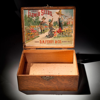

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an antique seed box from the 1890s, showcasing the historical significance of seed packets in American gardening culture. In the 19th century, seed packets were often displayed in decorative wooden boxes, adorned with vibrant company labels, serving as silent sales tools on store counters. This particular seed box is associated with D.M. Ferry & Co., a pioneering seed company that revolutionized retail display techniques by introducing the “commission box.” Acquired by the Smithsonian in 1986, it is part of a larger collection that highlights the evolution of advertising in gardening. Seed companies like D.M. Ferry & Co. also engaged with amateur gardeners by sending out seasonal catalogs,

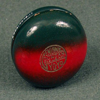

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable wooden yo-yo from the 1930s, produced by the Duncan Toys Company, highlighting the historical significance of the toy in American culture. The yo-yo's design, which includes a green surface with a bold red stripe, is attributed to Pedro Flores, a Filipino immigrant who introduced the toy to the United States. Flores's company, founded in 1928, was the first to produce wooden yo-yos, naming them “yo-yo,” which translates to “come-come” in his native language. By early 1932, Flores had established his own company and produced over 100,000 wooden yo-yos, understanding the importance of demonstrating the toy's tricks to attract buyers. The Duncan Toys Company, founded in 1932 by Fran

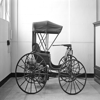

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Duryea Automobile, a significant artifact in the history of American transportation. Frank Duryea conducted a historic road test of this vehicle, a second-hand carriage equipped with a gasoline engine, on September 21, 1893, in Springfield, Massachusetts. The Duryea Motor Wagon Company, founded by Frank and his brother Charles in 1896, was the first American enterprise to produce and sell automobiles. The automobile is powered by a one-cylinder, four-cycle, four-horsepower, water-cooled gasoline engine, which is positioned almost horizontally under the carriage, and it includes a gear transmission, a spray carburetor, and make-and-break ignition. Acquired by the Smithsonian in 1920, th

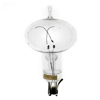

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Edison Light Bulb, an invention that revolutionized the way we illuminate our world. In 1879, Thomas Edison demonstrated this carbon-filament bulb at his laboratory in Menlo Park, New Jersey, marking a significant advancement in lighting technology. The bulb operates by conducting an electric current through a metal filament, causing it to heat to a glowing state. To ensure durability, the filament is enclosed in a glass bulb filled with inert gas to prevent oxidation. This demonstration was pivotal in Edison's legacy as a quintessential American inventor and entrepreneur, known for his resilience and unwavering belief in the promise of technology. The Edison Light Bulb is part of the 

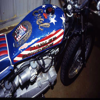

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Evel Knievel's custom 1972 Harley-Davidson XR-750, a motorcycle that symbolizes the extraordinary stunts and entertainment career of Evel Knievel, born Robert Craig Knievel. Knievel, whose real name was Robert Craig Knievel, became a national sensation in the 1960s, captivating audiences with his daring motorcycle jumps. The XR-750, weighing about 300 pounds and made from steel, aluminum, and fiberglass, was instrumental in many of his most impressive jumps, including a record-breaking leap over 14 Greyhound buses in 1975. Knievel's performances not only showcased his extraordinary skills but also captivated audiences, making him a household name in American pop culture.
==> Ground truth a

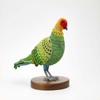

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Laurel Roth Hope's intriguing artwork, “Biodiversity Reclamation Suit: Carolina Parakeet,” created in 2009 and displayed at the Smithsonian American Art Museum. This piece employs humor to address the serious issue of species extinction, using crocheted suits that allow common rock pigeons to impersonate extinct North American birds. While it doesn't restore biodiversity, these creations certainly play with the idea. Hope's artistic process involves traditional methods such as carving, embroidery, crochet, and collage, transforming simple materials into intricate animal sculptures that are both whimsical and thought-provoking. Her work is deeply rooted in her experiences as a park ranger, 

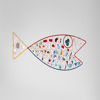

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Fish," a striking sculpture by Alexander Calder, created in 1945 and part of the Hirshhorn Museum and Sculpture Garden's collection in Washington, D.C. Calder, who was born into a family of artists, initially pursued a degree in mechanical engineering before embracing his artistic calling. After working as a freelance illustrator, he moved to Paris, where he was influenced by avant-garde artists and began to create wire sculptures that critics described as “drawings in space.” In 1931, inspired by the simplicity of Piet Mondrian's studio, he invented the “mobile,” a type of kinetic sculpture that moves with air currents. He also created “stabiles,” which are static sculptures, and standin

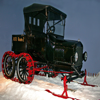

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a 1921 Ford Model T equipped with a unique snow attachment, illustrating the adaptive strategies of rural mail carriers in the early 1900s. As these carriers began utilizing automobiles, they soon realized that navigating snowy terrains posed significant challenges. In 1906, innovator Virgil White developed a solution by converting vehicles into snowmobiles with the Snowbird modification, which replaced front tires with skis and rear tires with caterpillar treads. This system allowed carriers to move more easily over snow and reduced the need for costly horses and sleds. The Ford Model T became the primary vehicle for White's kits, and by 1922, he had produced over 100,000 kits, selling th

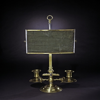

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant artifact: Thomas Jefferson's portable writing desk, which he used while drafting the Declaration of Independence in 1776. Designed by Jefferson himself, this desk includes a hinged writing board and a candle stand with adjustable candlesticks. The desk's historical significance is underscored by the fact that it was left behind by Jefferson on the evening of July 4, 1776, just before he presented the declaration to the Continental Congress. A British officer, Capt. John Huston, preserved the desk as a keepsake of that momentous occasion. In 1825, Huston gifted the desk to his granddaughter, who later donated it to the U.S. government. This artifact was first displayed at the 

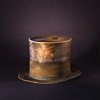

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features President Abraham Lincoln's top hat, a significant artifact housed at the Smithsonian's National Museum of American History. Standing at 6'4”, Lincoln was a towering figure, and his choice of high top hats further elevated his stature. This particular hat was crafted by Washington hat maker J.Y. Davis and features a black silk mourning band, a tribute to his son Willie, who died in 1862. While the exact date of acquisition is unknown, Lincoln last wore this hat on the evening of Good Friday, April 14, 1865, en route to Ford's Theatre. After his assassination, the War Department preserved the hat along with other personal items, and with Mary Lincoln's consent, it was transferred to the Smi

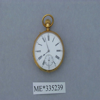

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that belonged to Helen Keller, born on June 27, 1880. Keller, who became deaf and blind at nineteen months due to an illness, was taught to communicate by Anne Sullivan, allowing her to become the first deaf-blind person to earn a Bachelor of Arts degree from Radcliffe College in 1904. The watch, a gift from John Hitz in 1892, is a Swiss-made device that allows time to be discerned through touch, with pins around its edge to indicate the hours. Keller cherished this watch throughout her life, even recovering it after it was lost in a taxi in New York City in 1952. Acquired by the Smithsonian in 1975, this watch not only represents Keller's remarkable achieveme

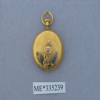

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an extraordinary pocket watch that belonged to Helen Keller, born on June 27, 1880. Keller, who became deaf and blind at nineteen months due to an illness, was taught to communicate by Anne Sullivan, allowing her to become the first deaf-blind person to earn a Bachelor of Arts degree from Radcliffe College in 1904. The watch, a gift from John Hitz in 1892, is a Swiss-made device that allows time to be discerned through touch, with pins around its edge to indicate the hours. Keller cherished this watch throughout her life, even recovering it after it was lost in a taxi in New York City in 1952. Acquired by the Smithsonian in 1975, this watch not only represents Keller's 

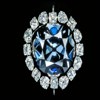

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a remarkable primary gem with a weight of 45.52 carats. The diamond is a captivating dark gray-blue color, characterized by its exceptional dark gray-blue coloration. It is skillfully cut into a modified antique cushion shape, enhancing its allure and elegance. This piece is a significant example of high-quality jewelry craftsmanship, showcasing the artistry and luxury associated with Cartier. Originally sourced from India, this necklace is a notable example of the high-quality gemstones that define the brand's identity. It is part of the Mineral Sciences collection, specifically within the Gems category, and is cataloged und

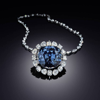

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace crafted by Cartier, Inc., showcasing a single primary gem weighing an impressive 45.52 carats. The diamond is a captivating dark gray-blue color, characterized by its exceptional dark gray-blue tone. It is skillfully cut into a modified antique cushion shape, enhancing its allure and elegance. This piece is a remarkable example of high-quality jewelry craftsmanship, showcasing the artistry and luxury associated with Cartier. Originating from India, this necklace is a significant specimen within the Mineral Sciences collection, specifically within the Gems category. It is currently not on view and was last modified on September 26, 2022. For f

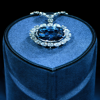

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Could you provide an overview of what is on display here?'}]}
==> User message + assistant prompt (text): User:<image>Could you provide an overview of what is on display here?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a stunning diamond necklace by Cartier, Inc., showcasing a single primary gem that weighs an impressive 45.52 carats. The diamond is a captivating dark gray-blue color, characterized by its exceptional dark gray-blue coloration. It is cut into a modified antique cushion shape, enhancing its allure and elegance. This piece is a remarkable example of high-quality jewelry craftsmanship, showcasing the artistry and luxury associated with Cartier. Originally sourced from India, this necklace is part of the Mineral Sciences collection at the Smithsonian's National Museum of Natural History, highlighting its significance in the world of gemsto

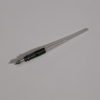

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an Esterbrook pen that holds significant historical importance as it was used by President Lyndon B. Johnson to sign the Civil Rights Act of 1964 on July 2, 1964. This pen, along with over 70 identical ones, was gifted to notable figures in the Civil Rights Movement as a gesture of recognition. The path to this pivotal legislation was complex, beginning with President John F. Kennedy's introduction of the bill before his assassination in November 1963. President Johnson's leadership was crucial for the bill's success, as it underwent extensive hearings and faced a historic 57-day filibuster in the Senate. The Civil Rights Act represented a significant advancement in the fight for equality,

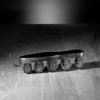

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Volito, an inline skate from 1823, crafted by Robert John Tyers. As the 2014 Winter Olympics highlight various ice sports, it's intriguing to consider how skaters of the past prepared for their sport without modern facilities. The Volito is notable for its unique design, which includes a wooden sole and a row of five wooden wheels, along with a curved iron bar that functions as a basic brake. Its most innovative feature is the unequal wheel sizes—larger in the center and smaller at the ends—enabling skaters to make sharper turns with greater ease. Although this remarkable artifact is part of the National Museum of American History's collection, it is currently not on display. For more 

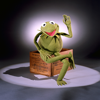

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Kermit the Frog, a celebrated character created by Jim Henson, who has been a staple of children's television since his debut in 1955 on "Sam and Friends." Kermit is known for his role as the host of "The Muppet Show" and as a key character on "Sesame Street." He is characterized by his calm demeanor amid the whimsical chaos of his surroundings and is particularly famous for the poignant song “Bein' Green,” which explores the challenges he faces due to his color. The puppet, made from a variety of materials including synthetic fiber and felt, measures 27 inches and is housed at the National Museum of American History. This exhibit is part of the "Entertainment Nation" exhibition, which exa

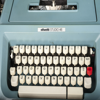

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the typewriter of the illustrious Octavia Estelle Butler (1947–2006), a groundbreaking figure in science fiction literature. Butler is celebrated for her influential works, including the five-volume Patternist series, the Xenogenesis trilogy—also known as Lilith's Brood—and the influential novels Parable of the Sower and Parable of the Talents, as well as the short story collection Bloodchild and Other Stories. Her writing is characterized by a unique fusion of African American history with speculative futures and alien psychology, a style that has become synonymous with Afrofuturism. By centering characters from the African diaspora in her early novels such as Wild See

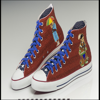

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features "Kiowa Ah-Day," a striking pair of sneakers crafted by Kiowa artist Teri Greeves in 2004. The sneakers, made from cotton canvas and adorned with intricate overlay beadwork, represent a fusion of traditional Native American artistry and modern footwear design. Measuring 33 x 11 x 15 cm, these sneakers were purchased by the National Museum of the American Indian from the Thirteen Moons Gallery in Santa Fe, New Mexico. This piece not only highlights the ongoing relevance of Native American art but also illustrates the evolution of cultural expression through everyday objects.
==> Ground truth answer: This exhibit features a remarkable piece titled "Kiowa Ah-Day," created by Kiowa artist Teri 

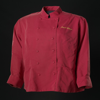

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable collection from the Smithsonian's National Museum of African American History and Culture, generously donated by Dooky Chase's Restaurant and Chef Leah Chase. Chef Chase, who passed away in 2019, famously stated, “We changed the world over a bowl of gumbo,” underscoring the restaurant's role as a venue for civil rights discussions. Known as “The Queen of Creole Cuisine,” she elevated New Orleans Creole cooking to international acclaim. Together with her husband, jazz musician Edgar “Dooky” Chase II, she transformed a modest sandwich shop into a fine-dining experience characterized by elegant white tablecloths and works by African American artists. The exhibit features Chase's red

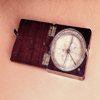

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a captivating pocket compass that dates back to around 1804, associated with the Lewis and Clark Expedition. Meriwether Lewis acquired this compass from Philadelphia instrument maker Thomas Whitney, purchasing it as part of a collection of scientific tools to support their groundbreaking journey. The compass is notable for its silver-plated rim, graduated in degrees, a paper dial, and two small brass sight vanes, all housed in a mahogany box with a leather carrying case. Its purpose—whether for Lewis's personal use or as a gift for his fellow explorer William Clark—is still a matter of speculation. The Corps of Discovery, led by President Jefferson, embarked on their expedition in May 1804

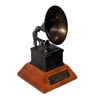

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the 1960 Grammy Award of Bob Newhart, a celebrated comedian and actor known for his deadpan delivery and incisive observations of American culture. Born on September 5, 1929, in Oak Park, Illinois, Newhart has enjoyed a remarkable career spanning over six decades. His debut comedy album, The Button-Down Mind of Bob Newhart, made history as the first comedy LP to reach No. 1 on the Billboard charts and won him a Grammy for Album of the Year, marking him as the only comedian to win the Best New Artist Grammy. He is also recognized as the only comedian to win the Grammy for Best New Artist. Newhart's television legacy includes starring roles in iconic sitcoms like The Bob Newhart Show and New

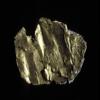

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant gold nugget from 1848, housed at the Smithsonian's National Museum of American History. This nugget is widely recognized as the first piece of gold discovered at Sutter's Mill in California, an event that sparked the gold rush. On January 24, 1848, James Marshall, while supervising the construction of a sawmill, noticed a shiny object in the mill's tailrace. Upon closer inspection, he identified it as a thin scale of what appeared to be pure gold. Marshall later shared this find with Capt. Joseph L. Folsom, who documented it as Specimen No. 1, marking it as the first gold discovered in Northern California. By August 1848, this nugget and other samples were sent to Washington,

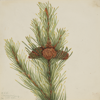

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a watercolor painting by Mary Vaux Walcott, created in 1921, which highlights the exquisite artistry of her time. The piece is part of the Smithsonian American Art Museum's collection, gifted by the artist in 1970. Walcott's journey into botanical illustration began after a botanist requested her to paint a rare arnica. After marrying Charles Doolittle Walcott, the Smithsonian's Secretary, in 1914, they spent summers in the Canadian Rockies, where she produced numerous watercolor studies of local flora. Her dedication led to the publication of 400 of her illustrations in the five-volume "North American Wild Flowers" between 1925 and 1929, and she later illustrated "North American Pitcher P

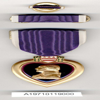

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the esteemed United States Purple Heart, a heart-shaped medal that symbolizes military bravery. The medal is crafted from a blend of copper alloy, gold plating, and non-magnetic white metal, showcasing a striking profile relief of George Washington. Above the bust is a shield that showcases Washington's family coat of arms. The reverse side bears the inscription "FOR MILITARY MERIT," signifying its prestigious award criteria. The medal is attached to a silk ribbon that is purple with a white edge stripe, enhancing its visual appeal. With dimensions of 3.7 cm by 1.1 cm by 8.1 cm, this artifact is part of the National Air and Space Museum collection, thanks to a donation from the United Stat

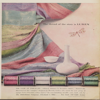

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an advertisement from the 1950s, showcasing the innovative work of Dorothy Liebes, a prominent American textile designer. Liebes is celebrated for her significant contributions to the design industry, particularly through her use of the Lurex technique, which involves applying metallic elements to fabrics to create a luxurious look. This technique, initially developed in the 1930s by the French textile manufacturer Hermes, was further popularized by Liebes, who collaborated with notable designers and architects, including Frank Lloyd Wright and Pauline Trigère. The advertisement is part of the Smithsonian's Archives of American Art and is also featured in the Cooper Hewitt, Smithsonian Des

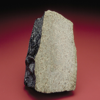

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a significant piece of meteorite: the Nakhla Meteorite Fragment, which is part of the Smithsonian's National Museum of Natural History collection. This meteorite fell to Earth on June 28, 1911, in Alexandria, Egypt, where it was observed exploding in the atmosphere before landing in about forty pieces, with a total mass of 22 pounds. The Smithsonian acquired two samples shortly after the fall, and in 1962, it added a notable 480-gram fragment, resulting in a total of 650 grams of Nakhla meteorite fragments by the 1970s. The Smithsonian's collection, which includes these fragments, is further enriched by a notable 480-gram piece that was added in 1985. By the 1990s, the museum had amassed a

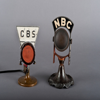

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an RCA Type 50-A microphone, a key artifact from President Franklin Delano Roosevelt's "Fireside Chats," which began on March 12, 1933. These informal radio addresses were revolutionary as they allowed Roosevelt to communicate directly with the American people, creating a sense of camaraderie and reassurance during the Great Depression. The first chat took place in the Lincoln Study, while later ones were held in the Diplomatic Reception Room of the White House. The microphone, bearing the National Broadcasting Company logos, was preserved by Carleton Smith, who was responsible for its setup. Acquired by the museum in 1996, this artifact is part of a larger collection that includes over 1,

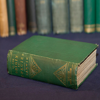

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Charles Darwin's seminal book, "On the Origin of Species," published in 1859, which is housed at the Smithsonian Institution Libraries. It commemorates the anniversary of the HMS Beagle's launch on May 11, 1820, a ship that would become pivotal in Darwin's scientific exploration. The Beagle embarked on its second survey voyage on December 27, 1831, with Darwin serving as a naturalist. Over the course of five years, the expedition to South America and the Galápagos Islands allowed Darwin to gather extensive data, including fossils and plant specimens, which informed his revolutionary theory of evolution by natural selection. The publication of "On the Origin of Species" was a landmark momen

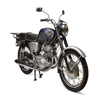

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Robert M. Pirsig's 1966 Honda Super Hawk motorcycle, a significant artifact from his seminal book, "Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values." Published in 1974, the book quickly became a bestseller, selling a million copies in its first year and initiating a global cultural movement that encouraged individuals to reassess their relationships with technology and strive for a more balanced life. The narrative was inspired by Pirsig's transformative motorcycle trip with his son Chris in 1968, during which they journeyed 5,700 miles from Minnesota to San Francisco. This experience deepened their father-son relationship and provided Pirsig with profound insights into s

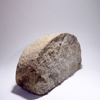

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Plymouth Rock Piece, an important artifact from 1620, located at the National Museum of American History. Traditionally regarded as the landing site of the Mayflower Pilgrims, this rock is steeped in history. William Bradford, a key figure in the settlement, is credited with the establishment of Thanksgiving in American culture. The rock has a tumultuous past; in 1774, it was moved from its original shoreline location to the town square, where it split into two halves. The lower half remained in its original spot, while the upper half was taken to the meeting house. In 1880, both halves were reunited, although many pieces had been taken as souvenirs. In the 1920s, the Plymouth Antiquar

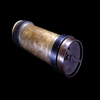

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Pneumatic Mail Container from 1953, an important artifact from the history of mail delivery. In the late 1800s, cities began implementing pneumatic tube systems beneath their streets to move mail swiftly. Each container, or carrier, could hold up to 500 letters and was propelled through the tubes by compressed air, reaching speeds of 35 miles per hour while spinning. At its peak, the system efficiently moved 6 million pieces of mail each day, with five carriers dispatched every minute. The first pneumatic tube service began in Philadelphia in 1893, followed by New York City in 1897, and eventually expanded to cities like Boston, Chicago, and St. Louis. By 1915, over 56 miles of pneumat

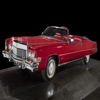

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking red 1973 Eldorado Cadillac, a vehicle that was once owned by the legendary Elvis Presley. Known for his impact on rock music, Presley's personal style is often characterized by his love for Cadillacs. This particular Cadillac was a significant part of his collection and was showcased in the documentary "Hail! Hail! Rock 'n' Roll," which celebrated his 60th birthday through two concerts. A memorable moment from the film occurs when Presley drives this Cadillac onto the stage of the Fox Theater in St. Louis, a venue that had previously denied him entry as a child due to racial discrimination. Presley's connection to this Cadillac is deepened by his lyrics that often mention cars, 

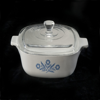

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a notable white casserole dish from CorningWare, dating back to 1965, which is adorned with the company's distinctive blue cornflower design. This dish is a testament to the evolution of kitchenware, as it was originally created for military applications during World War II. After the war, its versatility allowed it to be used for cooking, freezing, and serving, making it a staple in many kitchens. In the 1990s, CorningWare shifted towards ceramic stoneware to meet consumer demand for more colorful and varied designs, but the original glass-ceramic line returned in 2009 due to its enduring popularity. This particular dish is part of the National Museum of American Histo

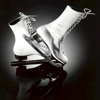

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the autographed ice skates of Sonja Henie, dating back to around 1945, at the Smithsonian's National Museum of American History. Henie, a Norwegian figure skater, is credited with transforming women's figure skating in the late 1920s and 1930s by introducing white leather skates, a stark contrast to the traditional black ones. She won her first world title in 1927 and went on to achieve ten consecutive titles, captivating audiences with her innovative choreography that combined dance with skating. Henie was also the first to popularize the short skirt and white skates that have become synonymous with women's figure skating today. Her Olympic accolades include three gold medals in the ladie

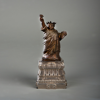

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features one of the first models of the Statue of Liberty, commonly known as the American Committee Model. Produced in the United States, this statuette was created in large quantities to finance the construction of the statue's pedestal in New York Harbor. The model is based on the design of French sculptor Frédéric-Auguste Bartholdi and was available in both six-inch and twelve-inch sizes. A national campaign promoted these statuettes at one dollar for the smaller model and five dollars for the larger one. Richard Butler, a rubber manufacturer from New York, led the American Committee that oversaw the production of these models. The campaign not only popularized the image of Liberty across the Un

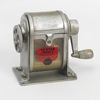

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Dexter Model 3 Pencil Sharpener, dating back to approximately 1920, produced by the Automatic Pencil Sharpener Company (APSCO) in Rockford, Illinois. Constructed from metal, cellulose, and painted wood, this sharpener measures 10.8 x 12.7 x 7 cm (4 1/4 in. x 5 in. x 2 3/4 in.) and is part of the Cooper Hewitt, Smithsonian Design Museum collection, thanks to a donation from Lucy Commoner. The Dexter Model 3 represents a significant advancement in pencil sharpener technology, featuring a rotating wheel with calibrated openings for various pencil sizes. While APSCO was a leading producer of mechanical sharpeners, it struggled to compete with the electric sharpener market and eventually fe

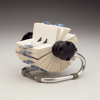

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'What can you tell me about this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>What can you tell me about this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Rolodex Open Rotary Card File, a staple of office organization that has become iconic over the years. Manufactured by the Rolodex Corporation in the USA, this item is constructed from a combination of materials including bent tubular metal, molded plastic, rubber, and paper, with dimensions of 18 x 18 x 16.5 cm. The Rolodex operates via a rotating cylindrical mechanism that allows users to easily access A-Z index cards for their business contacts. Despite the rise of digital alternatives, the Rolodex remains a beloved tool in many workplaces, symbolizing a blend of tradition and practicality. Its creation is attributed to Arnold Neustadter, a notable figure in offic

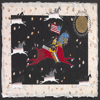

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: The exhibit features the "Lakota Horse Mask," a striking work by Jim Yellowhawk, created in 2008 and housed at the Smithsonian's National Museum of the American Indian. This piece, crafted from acrylic on paper and embellished with gold leaf, highlights the deep connection between American Indians and horses, often referred to as the Horse Nation. Horses were transformative for Native cultures, serving as essential allies in both peaceful times and wartime contexts. Originally, horses roamed the Americas over 40 million years ago but became extinct until Columbus brought them back in 1493. This artwork is part of the museum's collection and can be explored through the online exhibition “Horse Nation.” Additiona

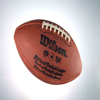

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Wilson Duke football, a significant artifact from Super Bowl XIV, which took place on January 20, 1980, at the Rose Bowl in Pasadena, California. The Wilson Sporting Goods Company introduced this football in the early 1940s, known for its exceptional leather quality and sewn ends, and it has been the official ball of the Super Bowl since Super Bowl II in 1968. The football on display was used during a thrilling game where the Pittsburgh Steelers defeated the Los Angeles Rams by a score of 31-19. This victory was notable as it marked the Steelers' fourth Super Bowl win and was highlighted by Terry Bradshaw's performance, which earned him the MVP title for the second consecutive year. Al

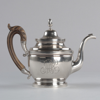

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a remarkable silver teapot crafted by Peter Bentzon, an American artisan active from around 1783 to after 1850. The teapot is distinguished by its elegant oval vase shape and is elegantly adorned with a spreading pedestal foot. Its hinged domed cover is topped with an incised patera, while the scroll handle is finished with wood and features a leaf cap. The teapot's side bears the monogram "MC," while the name "Rebecca Dawson" is engraved along the bottom rim, indicating its historical significance. Measuring 7 by 12 by 5 inches, this piece is part of the National Museum of African American History and Culture's collection, specifically within the Slavery and Freedom Objects category. It i

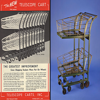

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Telescoping Shopping Cart, an invention that emerged around 1949, created by Orla E. Watson of Kansas City, Missouri. As the holiday season approaches, it's intriguing to consider how this cart might have influenced modern shopping experiences. The cart, which made its debut at Floyd's Super Market in 1947, is notable for its ability to nest for compact storage, allowing for only one-fifth of the space of a typical cart when parked. This exhibit is part of the Smithsonian's first major showcase on food history, which highlights the significant changes in food consumption and shopping habits in postwar America. For further exploration of food-related innovations, visitors can check out 

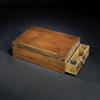

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features Thomas Jefferson's portable writing desk, a significant artifact from the time he drafted the Declaration of Independence in 1776. Jefferson, a delegate from Virginia, designed this desk with practical features, including a hinged writing surface and a locking drawer for storage of writing instruments. The desk accompanied him throughout his illustrious career, including his presidency, and was gifted to his granddaughter in 1825. In 1878, the Coolidge family donated this desk to the National Museum of American History, where it was initially housed in the Patent Office before being transferred to the museum in 1883. This desk not only represents a personal connection to the Declaration bu

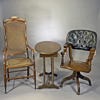

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features an important artifact from the Civil War era: the chair that General Ulysses S. Grant used while negotiating the surrender of the Confederate Army at Appomattox Court House on April 9, 1865. This chair, made of wood and measuring 37.5 inches in height, is a symbol of the momentous occasion. Grant, who was a key figure in the negotiations, is also known for signing the surrender agreement at the oval table, marking a significant turning point in the conflict. Following the surrender, Union officers took pieces of furniture as keepsakes, including Grant's chair and the table, which were later donated to the Smithsonian Institution and reunited by 1915. This exhibit is part of the "Price of F

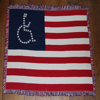

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a hand-altered lap blanket that has been modified to incorporate the universal access symbol, created by disability-rights advocates from the American Disabled for Attendant Programs Today (ADAPT). The blanket, made from cotton and measuring 129 cm by 95 cm, serves as a powerful emblem of the ongoing struggle for civil rights among disabled individuals. ADAPT, founded in 1983 in Denver, emerged from the post-World War II disability rights movement, which saw individuals with disabilities unite to advocate for their rights through various means, including community centers and online platforms. The blanket, with its stitched stars, powerfully conveys that freedom and independence belong to 

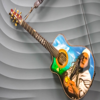

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the guitar of Carlos Vives, a Grammy Award-winning Colombian singer renowned for his vallenato music. Vallenato, a vibrant genre from Colombia's Atlantic coast, blends European instruments like the accordion with indigenous rhythms and poetic storytelling, rooted in the culture of the Arhuaco people. Historically, this music was performed by rural workers and cowboys, remaining largely local until the 1990s when Vives and other artists popularized it by merging it with pop and rock, thus reaching international audiences. The guitar on display, handmade by a Colombian luthier, showcases an airbrushed image of an Arhuaco and was last played by Vives at the Hollywood Bowl on September 7, 2016

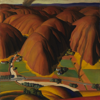

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features a striking painting by Ross Dickinson, an artist whose work emerged from the Public Works of Art Project during the Great Depression. Created in 1933, the artwork depicts California's Central Valley, where a river meanders through vibrant green fields at the foot of dry, rugged hills. The scene evokes the promise of a better life for those escaping the Dust Bowl, yet it is laced with tension. A small fire in the foreground and a larger plume of smoke in the distance serve as stark reminders of the dangers that exist even in paradise. This painting not only captures the beauty of California's landscape but also reflects the precariousness of life during the Great Depression.
==> Ground trut

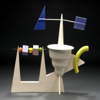

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the work of Peter Shire, an influential artist born in Los Angeles in 1947. The centerpiece is the Weathervane Teapot, a playful creation that showcases Shire's unique approach to ceramic art. Constructed from glazed ceramic, wood, and metal, this teapot is a whimsical arrangement of three-dimensional shapes, including squares, spheres, and curvy rods. Shire's intention was to challenge the traditional and often exclusive nature of "tea-time," making it an experience that is open to everyone. The teapot's unconventional design invites viewers to engage with it, raising questions about how to handle it and whether it can effectively pour tea. After 1985, Shire shifted his focus to furniture

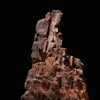

==> Original user message: {'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': 'Can you describe this exhibit?'}]}
==> User message + assistant prompt (text): User:<image>Can you describe this exhibit?<end_of_utterance>
Assistant:
==> Model generated answer: This exhibit features the Spotsylvania tree stump, a powerful artifact from the Civil War, located at the Smithsonian's National Museum of American History. Once a large oak tree in a quiet meadow near Spotsylvania Court House, Virginia, it was forever altered on May 12, 1864, when it became part of the infamous Bloody Angle during a fierce battle. The stump is riddled with Minié balls, a testament to the ferocity of the skirmish. The Battle of Spotsylvania Court House, which lasted from May 8 to May 21, resulted in approximately 31,000 casualties. Originally presented to the U.S. Army's Ordnance Museum by Brevet Maj. Gen. Nelson A. Miles, the stump was transferred to the Smithsonian in 1888 and is now prominen

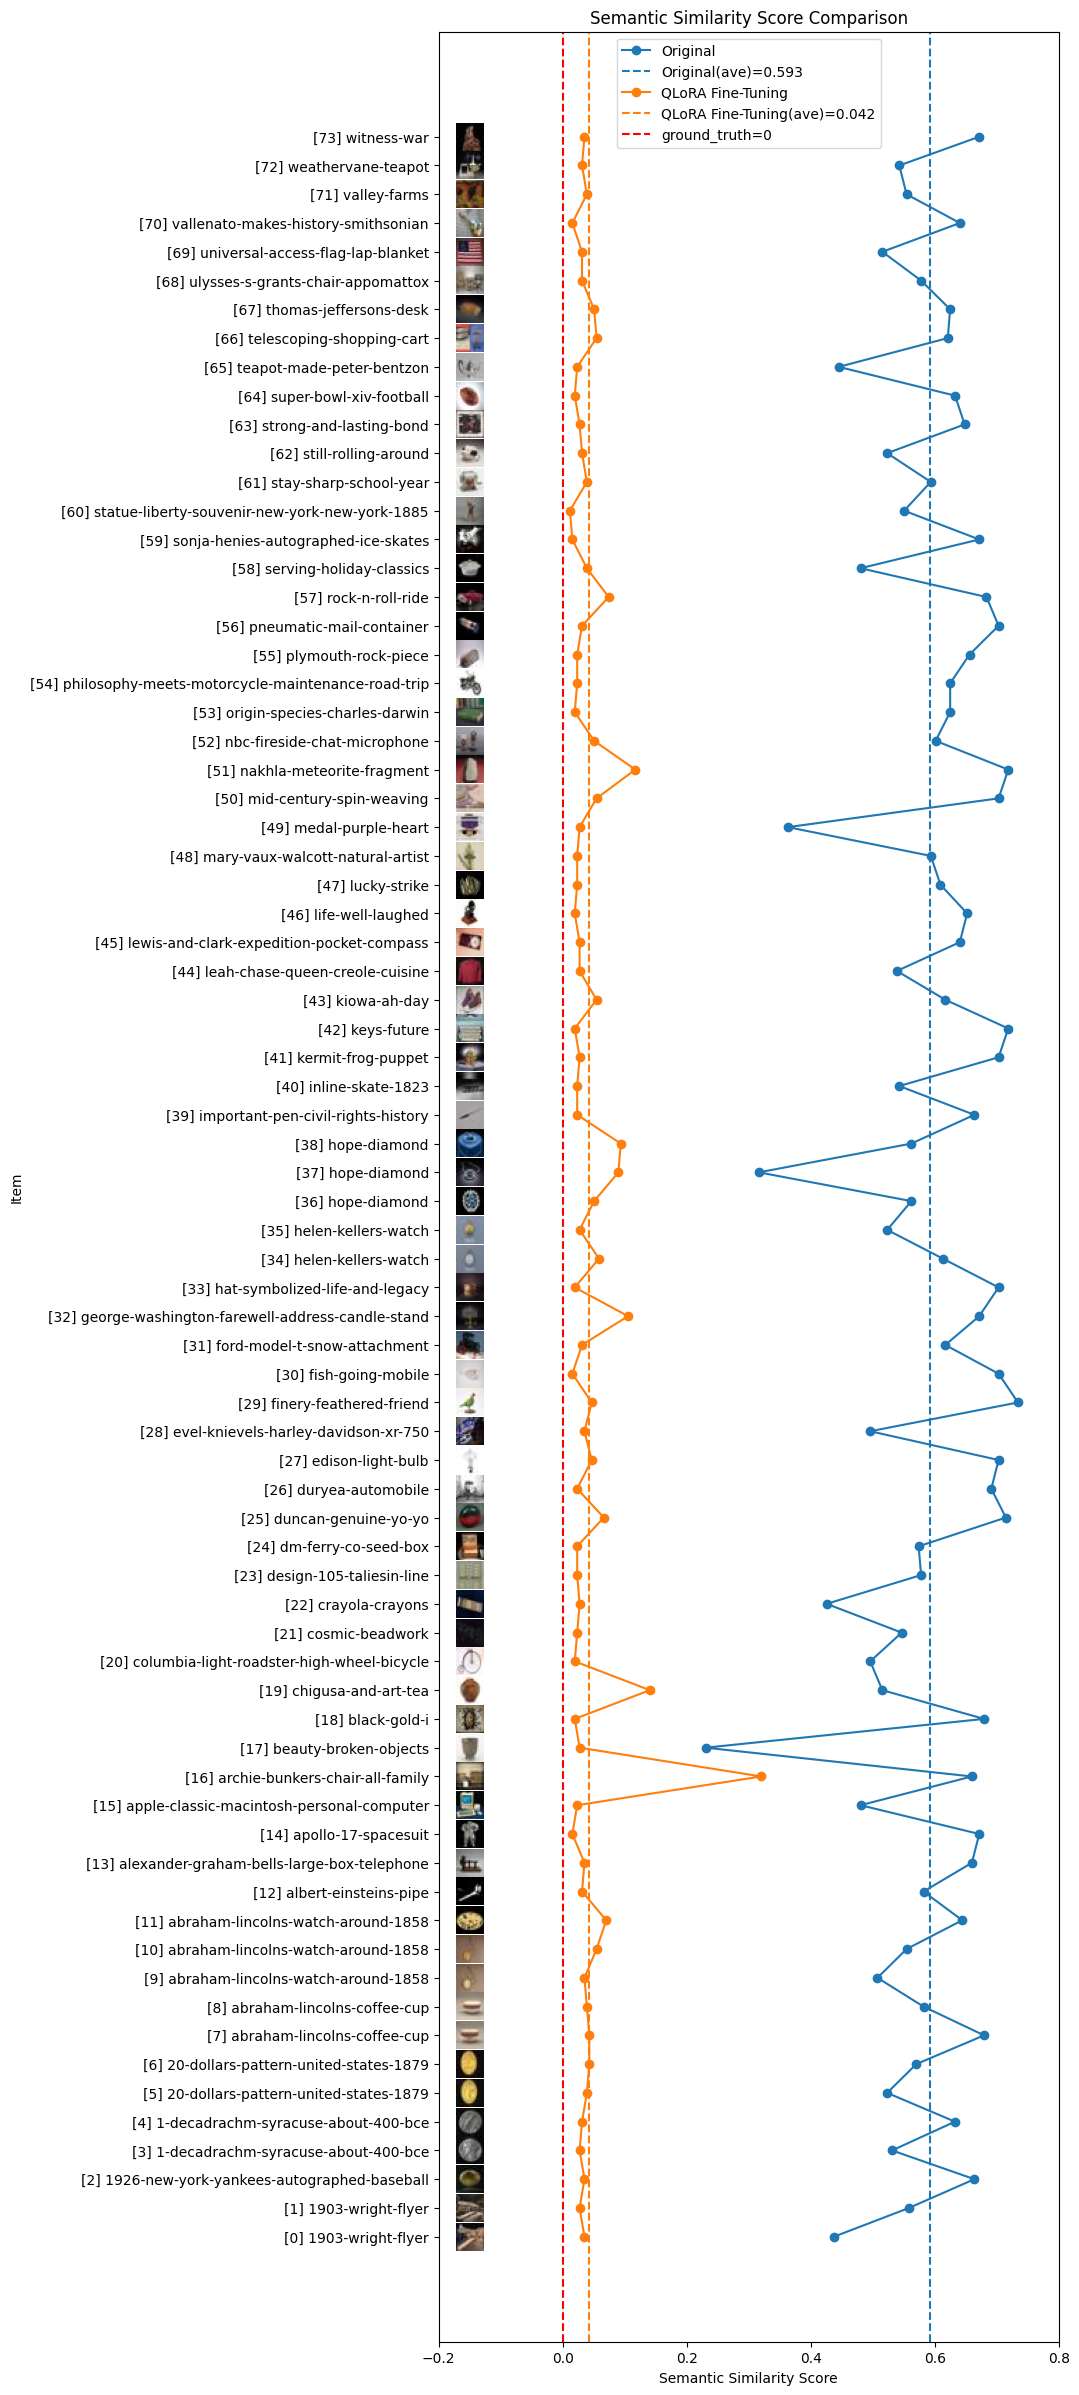

In [2]:
# Load the Hugging Face dataset
dataset = my_utils.load_hf_dataset(hf_path='xugefu/MuseQuest')

# Perform batch inference on the test set and save results to a CSV file
my_utils.batch_inference_model(lora_model, processor, dataset['test'], './results/inference_results/inference_results_after_finetuning.csv', 3)

# Plot similarity scores (original vs. fine-tuned) from the inference CSV files, using thumbnails, and save the plot image locally
my_utils.plot_similarity_scores([('Original', './results/inference_results/inference_results_before_finetuning.csv'),
                                 ('QLoRA Fine-Tuning', './results/inference_results/inference_results_after_finetuning.csv')],
                                thumbnail_dir='./results/inference_results/thumbnail',
                                plot_file_name='./results/inference_results/similarity_scores_after_finetuning.jpg')


## 4.4 Save the Fine-Tuned Model Locally  

In [3]:
# Merge base model with LoRA adapter
print(f'==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...')
merged_model = lora_model.merge_and_unload()

# Save processor
print(f'==> Saving processor...')
my_utils.print_processor_info_to_file(processor, './results/model_info/updated_processor_info.txt')
processor.save_pretrained(save_directory='./results/finetuned_model')

# Save fine-tuned model
print(f'==> Saving fine-tuned model...')
my_utils.print_model_info_to_file(merged_model, './results/model_info/finetuned_model_info.txt')
my_utils.print_model_parameters_to_file(merged_model, './results/model_info/finetuned_model_parameters.txt')
merged_model.save_pretrained(save_directory='./results/finetuned_model')


==> Creating fine-tuned model by merging base model weights with LoRA adapter weights...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:336: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


==> Saving processor...
==> Printing processor info...
==> Regular token count: 32000, regular+special token count: 32004, bos_token: <s>, eos_token: </s>, pad_token: <pad>
==> For complete processor info, refer to ./results/model_info/updated_processor_info.txt.
==> Saving fine-tuned model...
==> Printing model info...
==> Model type: Idefics2ForConditionalGeneration
==> Model is located on device: cuda:0
==> Model device map: {'': 0}
==> For complete model info (type, architecture, config, generation config, device map), refer to ./results/model_info/finetuned_model_info.txt.
==> Printing model parameters...
model.vision_model.embeddings.patch_embedding.weight (677376, torch.bfloat16, cuda, False)
model.vision_model.embeddings.patch_embedding.bias (1152, torch.bfloat16, cuda, False)
model.vision_model.embeddings.position_embedding.weight (5644800, torch.bfloat16, cuda, False)
model.vision_model.encoder.layers.0.self_attn.k_proj.weight (663552, torch.uint8, cuda, False)
model.vision_m